In [7]:
import pandas as pd
import numpy as np
import collections
from sklearn import model_selection
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE

In [8]:
raw = pd.read_csv("Z:\DataCollection\ActiveSensorimotorTrainingForChronicStroke(RFP)\Processed Data\Mean_training_data.csv")
raw.drop(["subject"], axis = 1, inplace=True)
raw["t_pd200_target"] = raw["t_pd200_target"].replace('#VALUE!', float('nan'))
raw["t_pd200_target"] = raw["t_pd200_target"].astype(float)


OSError: [Errno 22] Invalid argument: 'Z:\\DataCollection\\ActiveSensorimotorTrainingForChronicStroke(RFP)\\Processed Data\\Mean_training_data.csv'

In [9]:
raw.drop(['t_meanpd_target',  't_pd_target', 't_pdmaxv_target', "sparc"], axis = 1, inplace = True)

scores = ["FMA", "NSA", "MT", "FAS"]


KeyError: "['t_meanpd_target', 't_pd_target', 't_pdmaxv_target', 'sparc'] not found in axis"

In [ ]:
def study_score(raw, score_to_study):
    scores_to_remove = ["FMA", "NSA", "MT", "FAS"]
    scores_to_remove.remove(score_to_study)
    columns_with_element = [col for col in raw.columns if any(score in col for score in scores_to_remove)]
    data = raw.drop(columns_with_element, axis=1)
    data = data.dropna()
    return data

In [10]:
def train_test_split_data(data, score_to_study):
    # get y and drop y from data
    y_col = [col for col in data.columns if score_to_study in col]
    y = data[y_col]
    X = data.drop(y_col, axis = 1)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def tune_hyperparameter(X_train, X_test, y_train, y_test):
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 5],
        'min_child_weight': [1, 2],
    }

    rf_param_grid = {
        'n_estimators': [100, 200],
        'criterion':["squared_error", "poisson"],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt', 'log2'],
    }

    # model instances
    xgb = XGBRegressor(random_state=2023)
    rf = RandomForestRegressor(random_state=2023)

    # GridSearchCV
    xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=3, verbose = 1)
    rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=3, verbose = 1)


    # Fit the models to your training data (X_train, y_train)
    rf_grid.fit(X_train, y_train)
    xgb_grid.fit(X_train, y_train)

    # Get the best hyperparameters and models
    best_rf_model = rf_grid.best_params_
    best_xgb_model = xgb_grid.best_params_


    # Print the best hyperparameters and accuracy scores
    print("Random Forest - Best Hyperparameters:", best_rf_model)

    print("XGBoost - Best Hyperparameters:", best_xgb_model)

    return best_rf_model, best_xgb_model




def run_mode(X_train, X_test, y_train, y_test, best_param, model = "xgb"):
    if model == "xgb":
        print("RESULTS FOR XGBOOST REGRESSOR")
        # Create and train the XGBoostRegressor xgb
        model = XGBRegressor(**best_param, random_state=2023)
    if model == "rf":
        print("RESULTS FOR RANDOM FOREST REGRESSOR")
        # Create and train the XGBoostRegressor xgb
        model = RandomForestRegressor(**best_param, random_state=2023)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate various regression metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    # same units as the target variable
    # RMSE = (MSE)^1/2
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # MAE measures the average absolute difference between predicted values and actual 
    # MAE = (1/n) * Σ|y_true - y_pred|
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # a statistical metric used to measure the goodness of fit of a regression model
    print(f"R-squared (R2): {r2:.2f}")
    
    # Get feature importance scores
    feature_importance = model.feature_importances_

    # Create a DataFrame to display feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

    # Sort the DataFrame by importance scores in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the top 10 features
    top_10_features = feature_importance_df.head(10)
    print(top_10_features)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features['Feature'], top_10_features['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Features')
    plt.gca().invert_yaxis()
    plt.show()

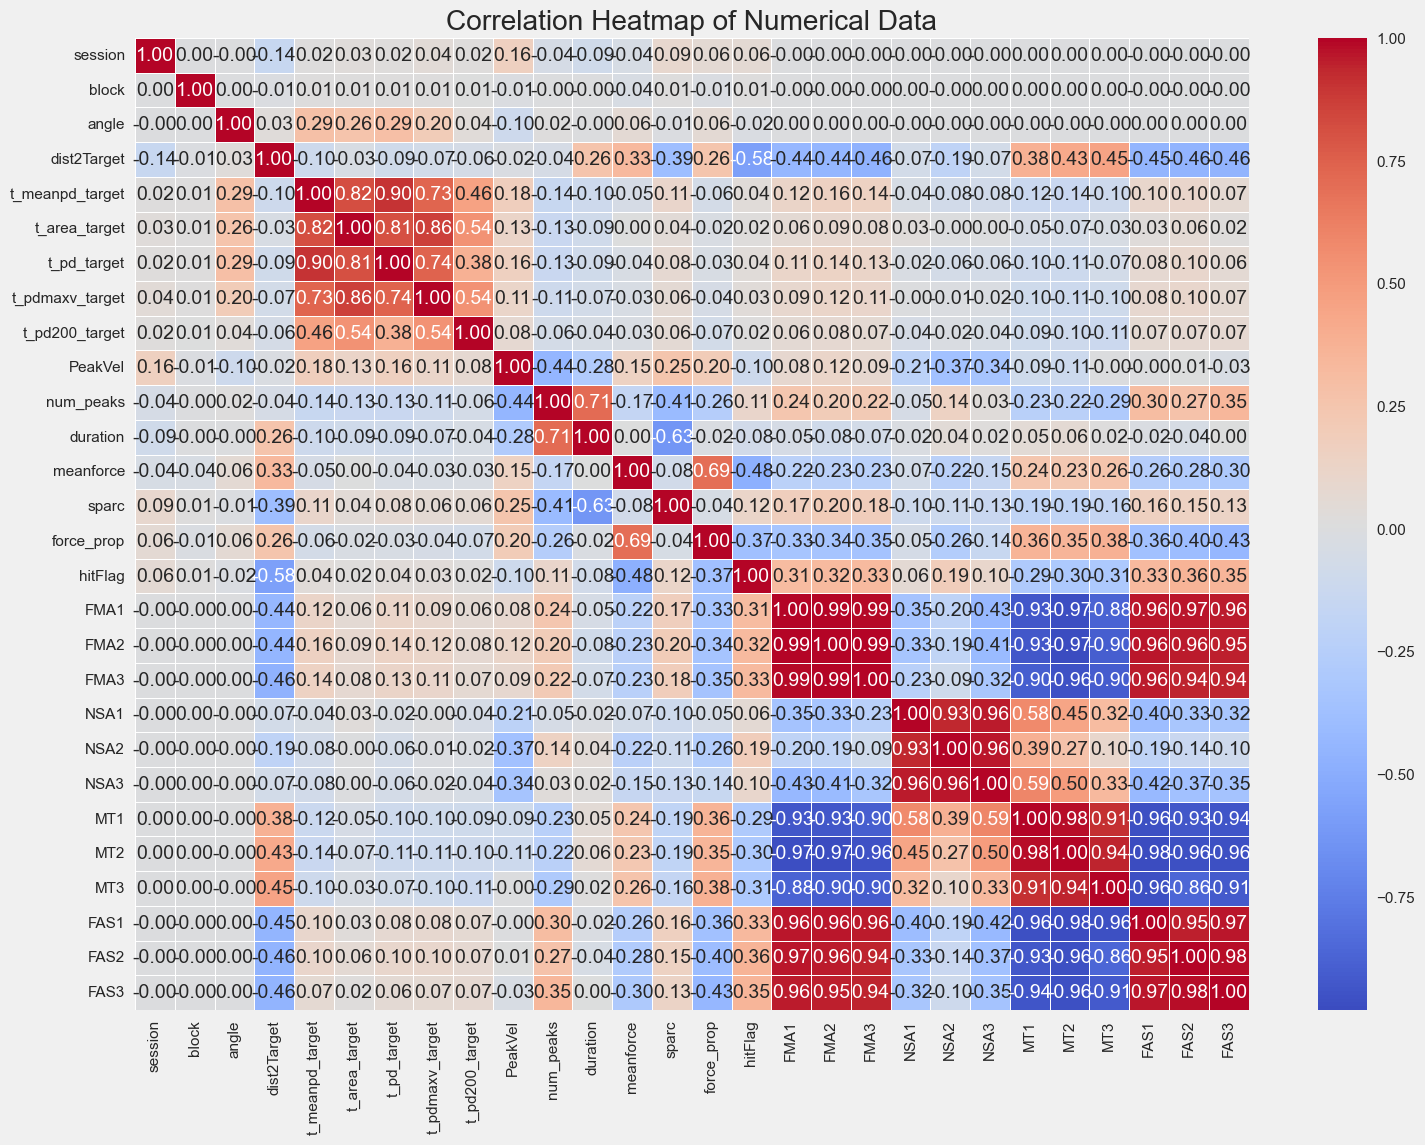

In [160]:
%matplotlib inline
# check for collinearity
numerical_df = raw.select_dtypes(include=["number"])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Data')
plt.show()

# without RPE

======================================== FMA ========================================
------------------- FMA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.51
Mean Absolute Error (MAE): 6.32
R-squared (R2): 0.67
       Feature      Importance
3      dist2Target   0.208735 
10      force_prop   0.135993 
6          PeakVel   0.119976 
7        num_peaks   0.100195 
8         duration   0.091806 
9        meanforce   0.074381 
4    t_area_target   0.070808 
5   t_pd200_target   0.060845 
0          session   0.049185 
11         hitFlag   0

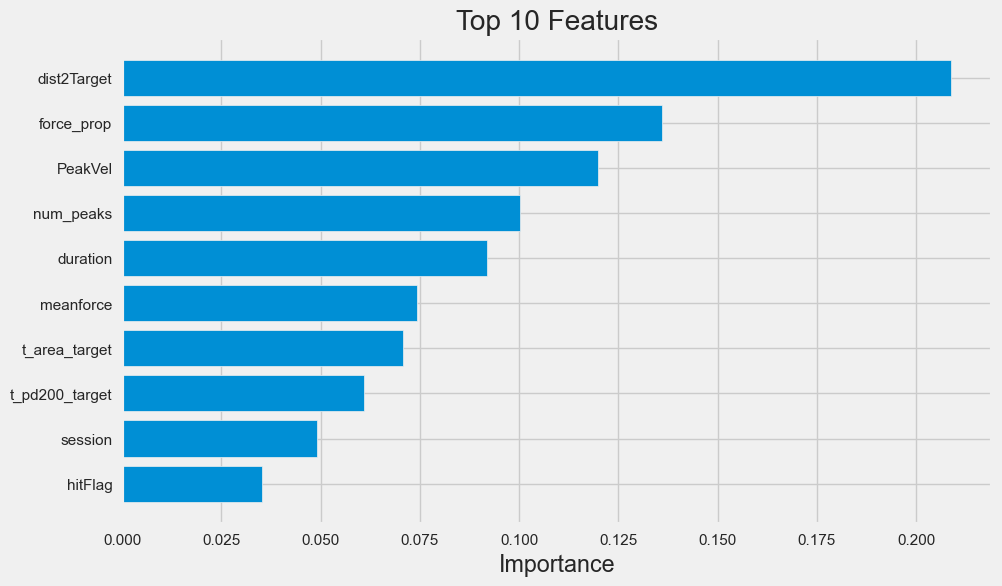

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.39
Mean Absolute Error (MAE): 6.47
R-squared (R2): 0.68
      Feature      Importance
3     dist2Target   0.249746 
7       num_peaks   0.191469 
10     force_prop   0.117731 
6         PeakVel   0.112655 
8        duration   0.070197 
4   t_area_target   0.045573 
11        hitFlag   0.045198 
9       meanforce   0.045065 
2           angle   0.042203 
0         session   0.039744 


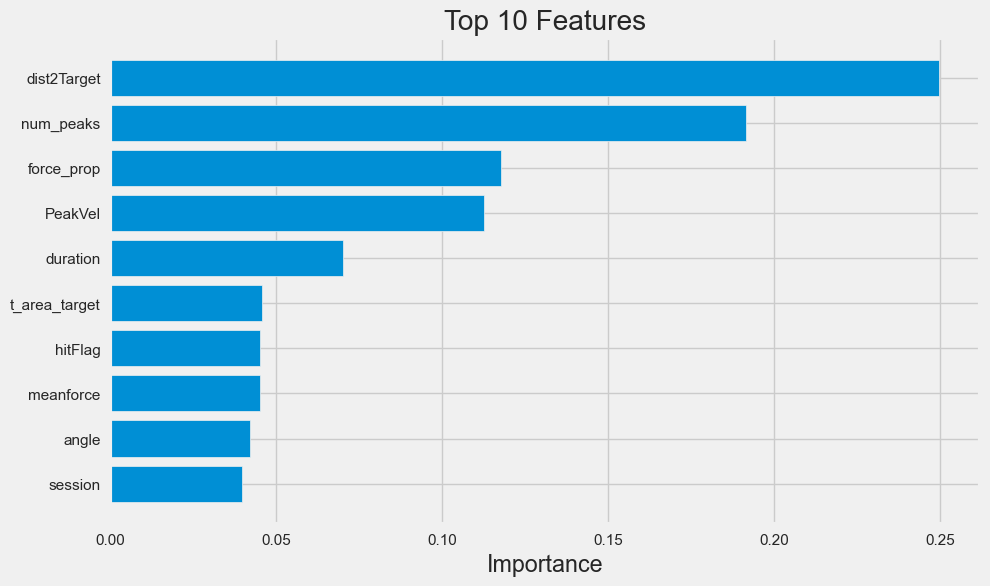

------------------- FMA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.27
Mean Absolute Error (MAE): 6.12
R-squared (R2): 0.68
       Feature      Importance
3      dist2Target   0.215493 
10      force_prop   0.136560 
6          PeakVel   0.117127 
7        num_peaks   0.092804 
8         duration   0.089650 
9        meanforce   0.077078 
4    t_area_target   0.071113 
5   t_pd200_target   0.062589 
0          session   0.049791 
11         hitFlag   0.035587 


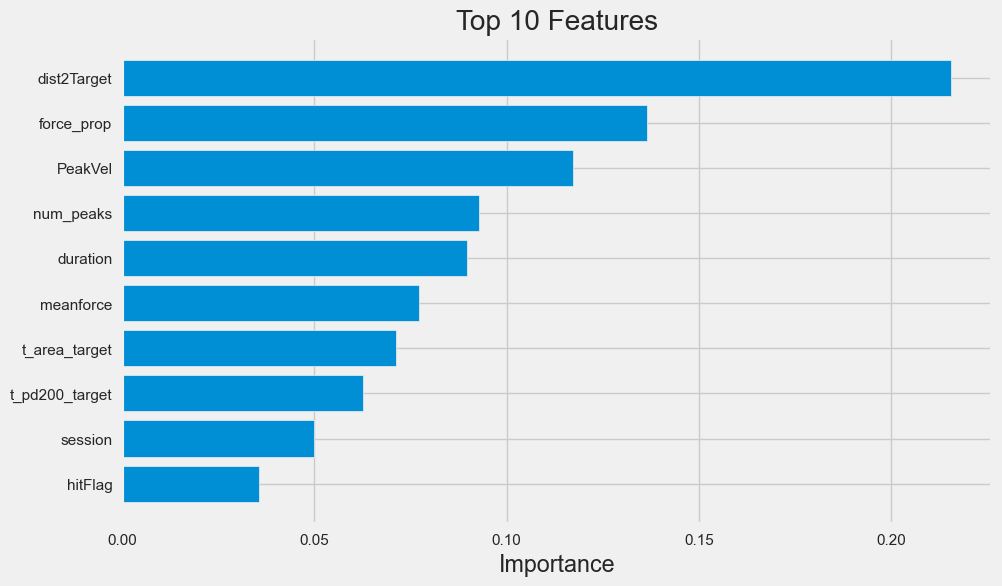

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.21
Mean Absolute Error (MAE): 6.34
R-squared (R2): 0.68
      Feature      Importance
3     dist2Target   0.238760 
7       num_peaks   0.173194 
10     force_prop   0.115533 
6         PeakVel   0.113913 
11        hitFlag   0.055861 
8        duration   0.055140 
9       meanforce   0.054485 
2           angle   0.048686 
0         session   0.046271 
4   t_area_target   0.044084 


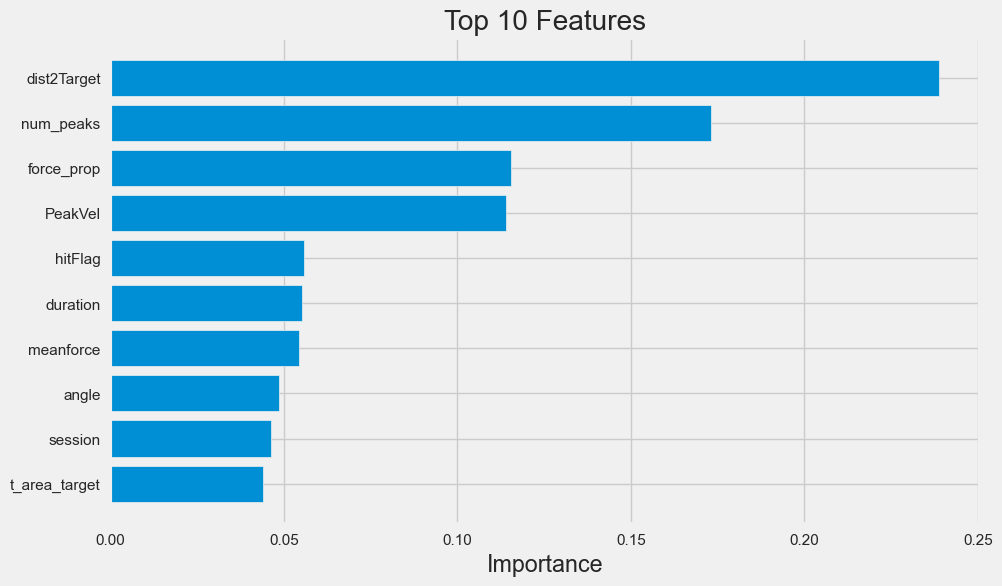

------------------- FMA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.02
Mean Absolute Error (MAE): 5.91
R-squared (R2): 0.67
       Feature      Importance
3      dist2Target   0.227425 
10      force_prop   0.134411 
6          PeakVel   0.105385 
7        num_peaks   0.096237 
9        meanforce   0.081845 
8         duration   0.081411 
4    t_area_target   0.068754 
5   t_pd200_target   0.058906 
0          session   0.047872 
11         hitFlag   0.047640 


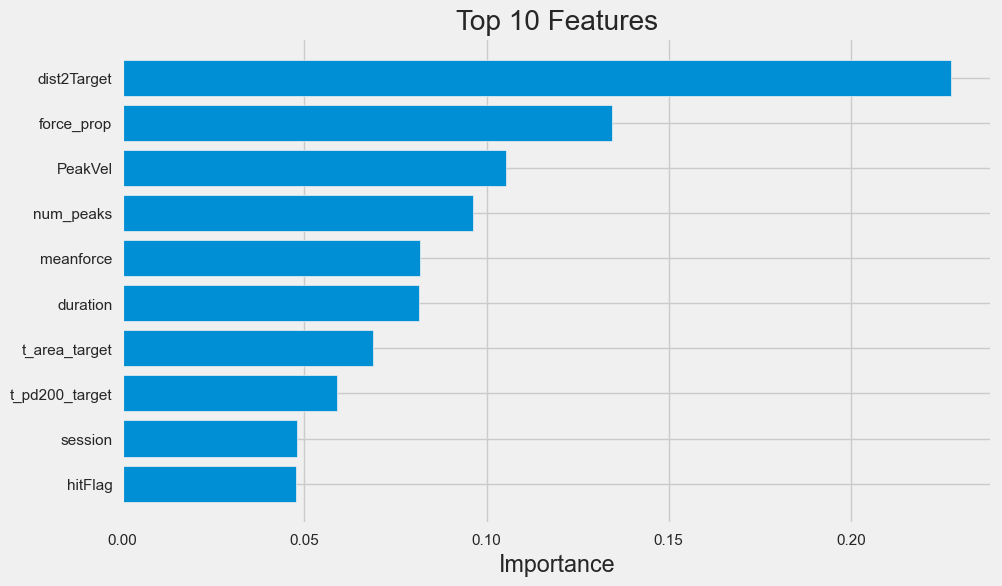

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.00
Mean Absolute Error (MAE): 6.15
R-squared (R2): 0.67
      Feature      Importance
3     dist2Target   0.255549 
7       num_peaks   0.161713 
10     force_prop   0.110926 
6         PeakVel   0.099553 
9       meanforce   0.063725 
11        hitFlag   0.063327 
8        duration   0.060732 
4   t_area_target   0.051102 
2           angle   0.046486 
0         session   0.043930 


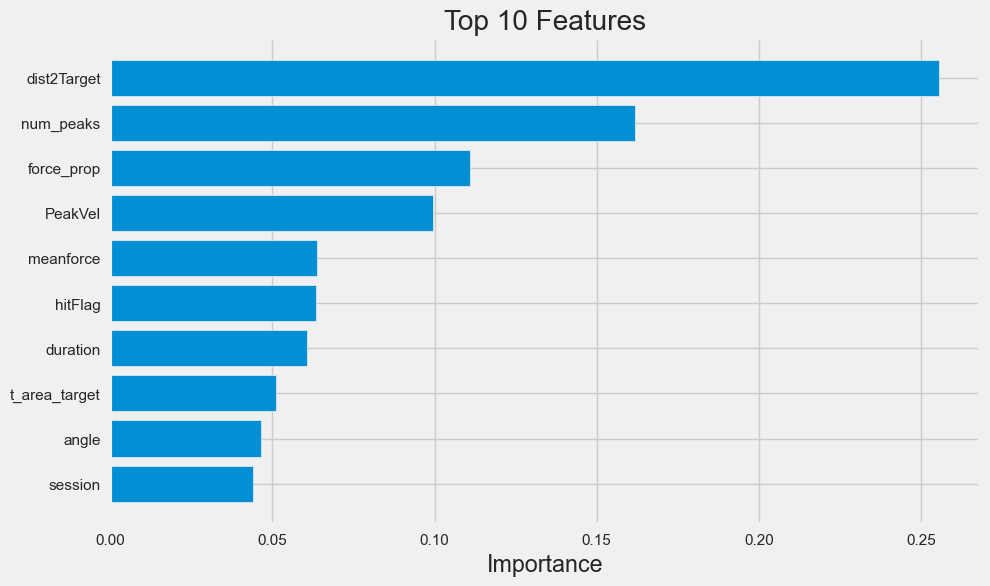

======================================== NSA ========================================
------------------- NSA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.96
Mean Absolute Error (MAE): 4.18
R-squared (R2): 0.66
       Feature      Importance
10      force_prop   0.154034 
9        meanforce   0.127387 
6          PeakVel   0.121788 
7        num_peaks   0.114594 
8         duration   0.106271 
3      dist2Target   0.086367 
4    t_area_target   0.080512 
5   t_pd200_target   0.070028 
0          session   0.055123 
2            angle   0.

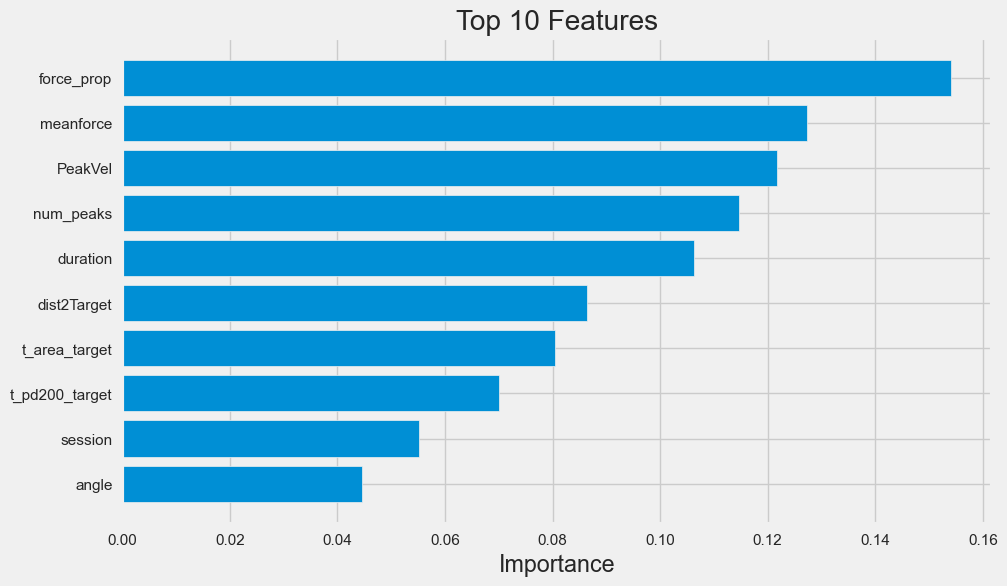

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 6.04
Mean Absolute Error (MAE): 4.30
R-squared (R2): 0.65
      Feature      Importance
11        hitFlag   0.338765 
7       num_peaks   0.127826 
9       meanforce   0.104717 
8        duration   0.076497 
10     force_prop   0.075269 
6         PeakVel   0.062620 
2           angle   0.058747 
3     dist2Target   0.047593 
0         session   0.040996 
4   t_area_target   0.032242 


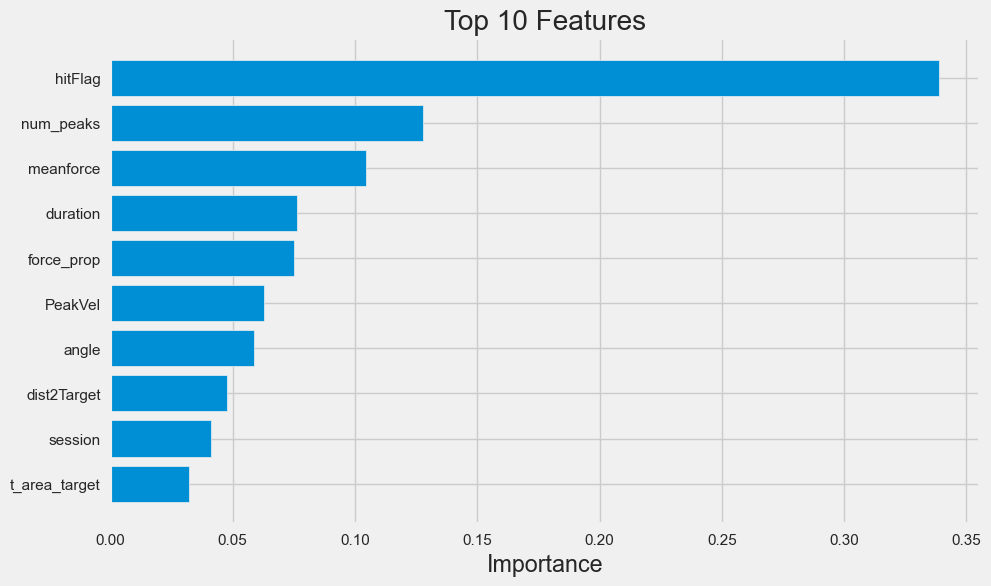

------------------- NSA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.51
Mean Absolute Error (MAE): 3.75
R-squared (R2): 0.75
       Feature      Importance
9        meanforce   0.183027 
10      force_prop   0.154726 
6          PeakVel   0.144444 
3      dist2Target   0.095385 
8         duration   0.089708 
7        num_peaks   0.082753 
4    t_area_target   0.064866 
5   t_pd200_target   0.057526 
0          session   0.045134 
2            angle   0.039063 


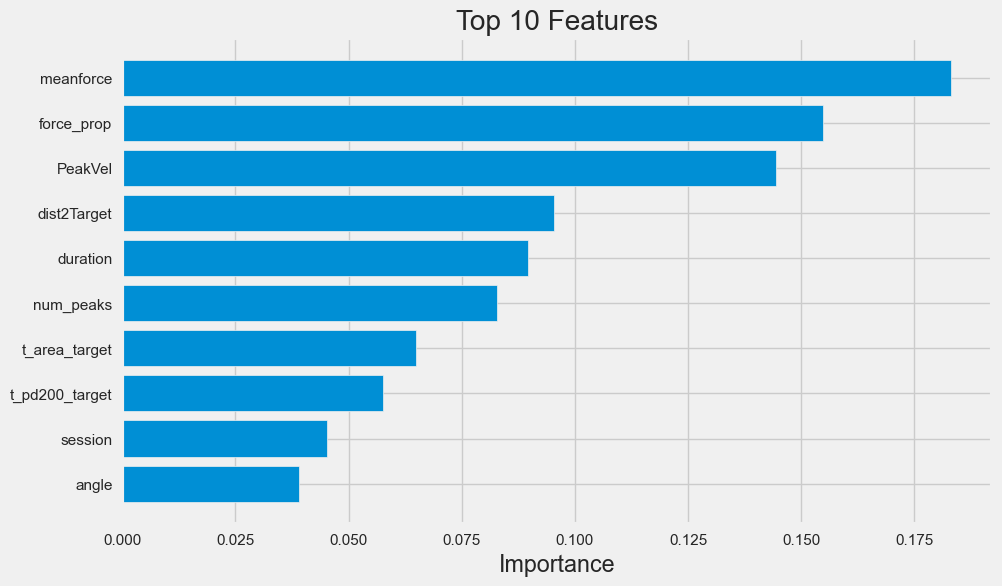

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 5.61
Mean Absolute Error (MAE): 3.92
R-squared (R2): 0.74
      Feature      Importance
11        hitFlag   0.420591 
9       meanforce   0.197319 
7       num_peaks   0.078444 
6         PeakVel   0.067417 
8        duration   0.050180 
3     dist2Target   0.046253 
2           angle   0.037252 
10     force_prop   0.035812 
0         session   0.026678 
4   t_area_target   0.018870 


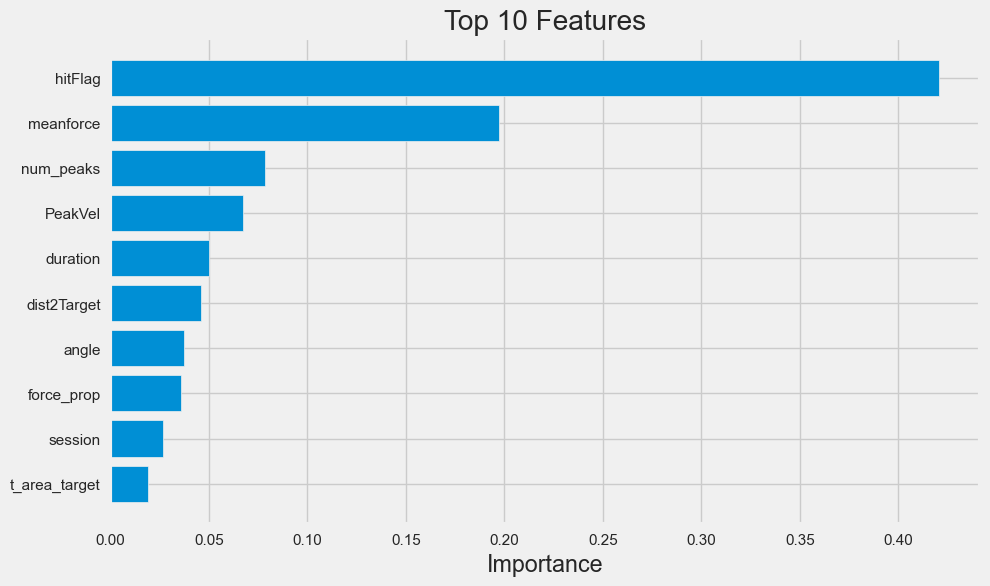

------------------- NSA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.91
Mean Absolute Error (MAE): 3.94
R-squared (R2): 0.72
       Feature      Importance
9        meanforce   0.163267 
6          PeakVel   0.151327 
10      force_prop   0.147184 
8         duration   0.097257 
7        num_peaks   0.090595 
3      dist2Target   0.086094 
4    t_area_target   0.066304 
5   t_pd200_target   0.061070 
0          session   0.049260 
2            angle   0.043981 


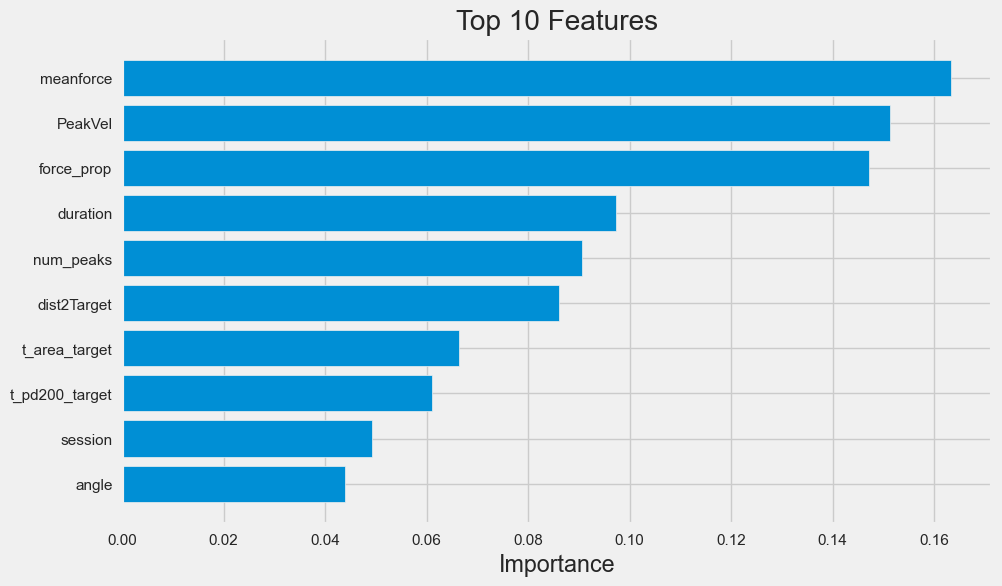

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 6.01
Mean Absolute Error (MAE): 4.13
R-squared (R2): 0.71
      Feature      Importance
11        hitFlag   0.399203 
9       meanforce   0.137771 
7       num_peaks   0.110555 
8        duration   0.074671 
6         PeakVel   0.069710 
10     force_prop   0.041935 
2           angle   0.041642 
3     dist2Target   0.040969 
0         session   0.035800 
4   t_area_target   0.023392 


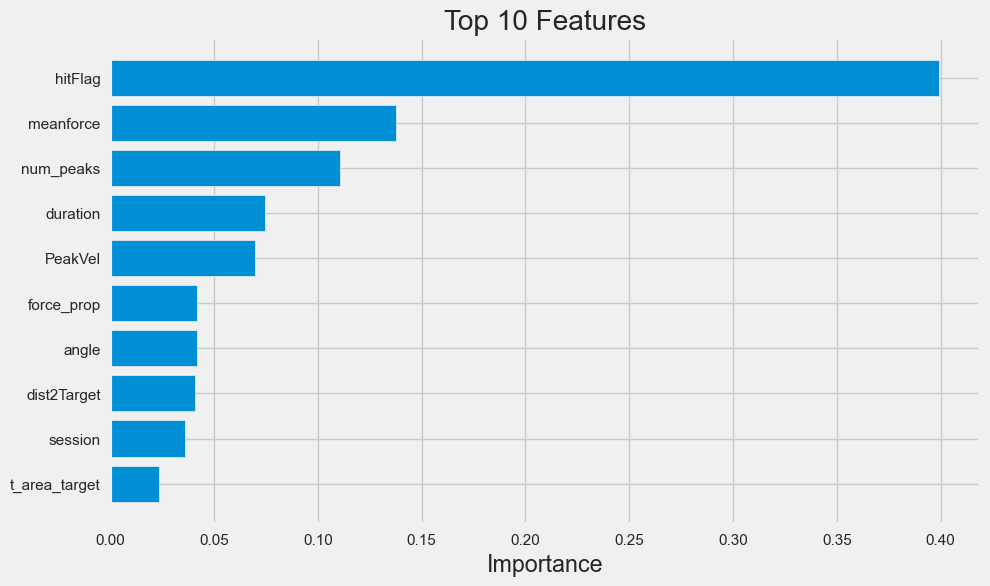

======================================== MT ========================================
------------------- MT1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 18.05
Mean Absolute Error (MAE): 11.59
R-squared (R2): 0.68
       Feature      Importance
3      dist2Target   0.167983 
10      force_prop   0.162170 
6          PeakVel   0.115189 
7        num_peaks   0.114177 
8         duration   0.098988 
9        meanforce   0.080544 
4    t_area_target   0.067735 
5   t_pd200_target   0.061100 
0          session   0.047100 
2            angl

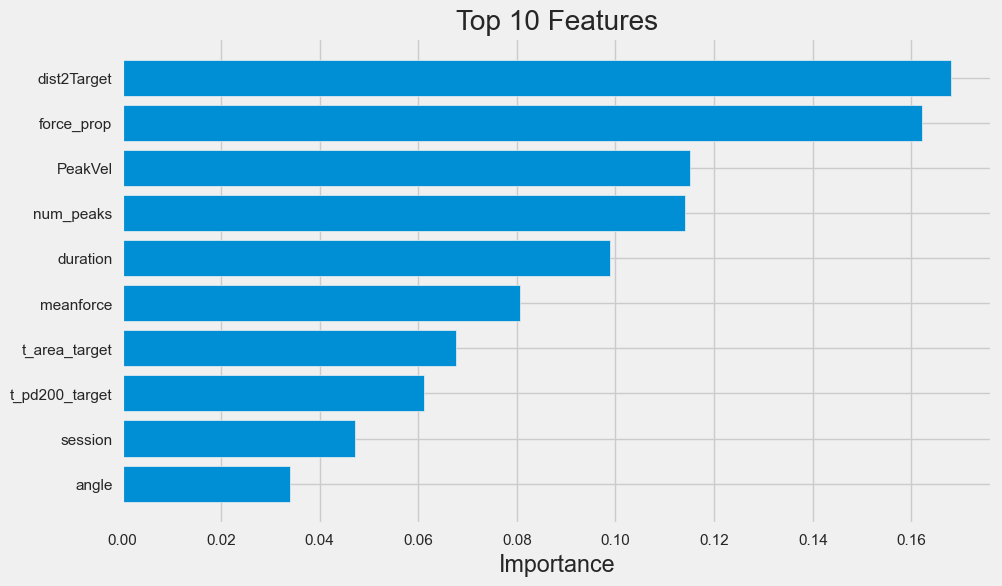

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 17.77
Mean Absolute Error (MAE): 11.72
R-squared (R2): 0.69
       Feature      Importance
3      dist2Target   0.196631 
7        num_peaks   0.181351 
10      force_prop   0.141201 
6          PeakVel   0.116510 
8         duration   0.097247 
2            angle   0.060111 
0          session   0.044265 
5   t_pd200_target   0.039596 
11         hitFlag   0.038737 
9        meanforce   0.038529 


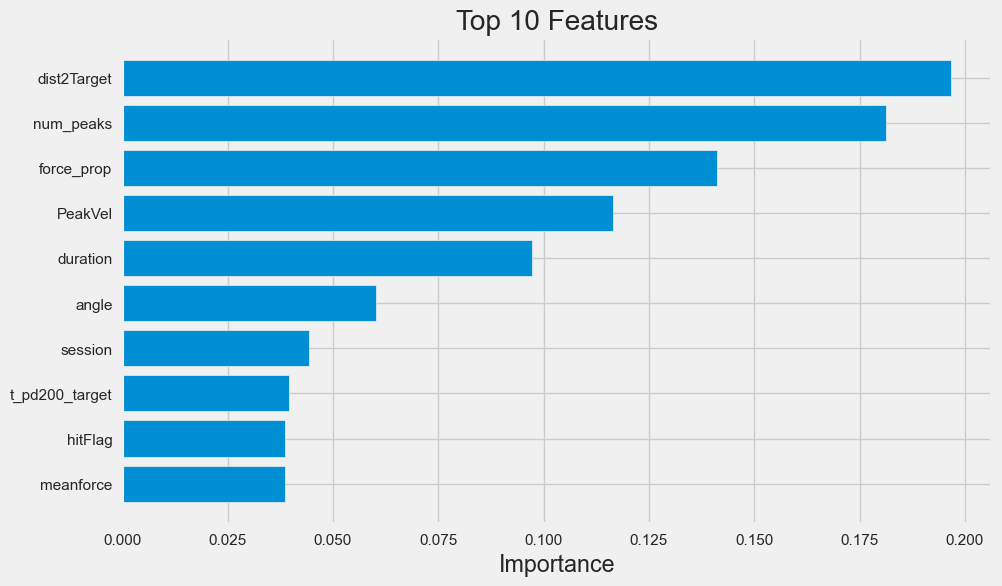

------------------- MT2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 16.14
Mean Absolute Error (MAE): 9.81
R-squared (R2): 0.68
       Feature      Importance
3      dist2Target   0.184217 
10      force_prop   0.145993 
7        num_peaks   0.110094 
6          PeakVel   0.099478 
9        meanforce   0.095896 
8         duration   0.089377 
4    t_area_target   0.068300 
5   t_pd200_target   0.062071 
0          session   0.046383 
11         hitFlag   0.042958 


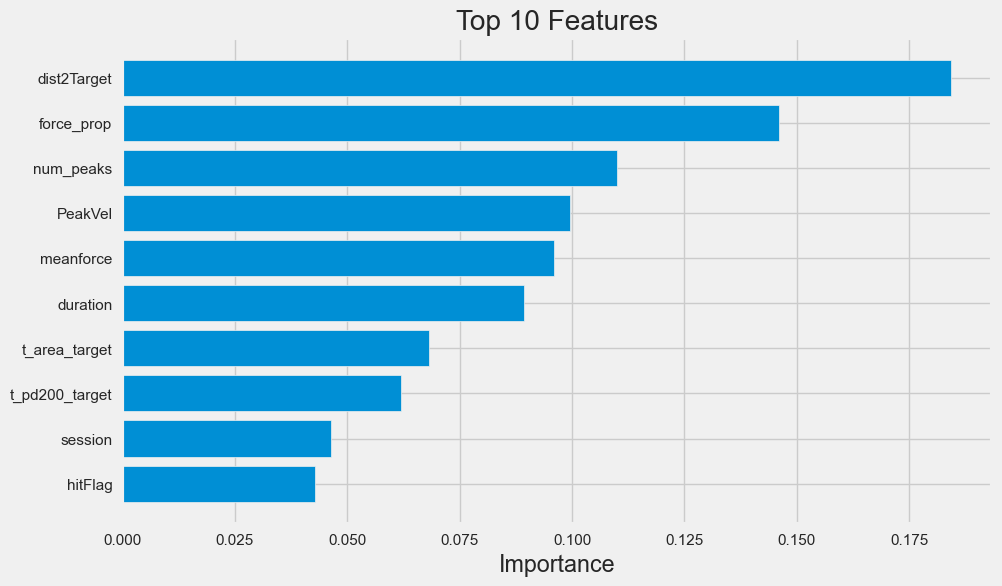

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 16.05
Mean Absolute Error (MAE): 10.21
R-squared (R2): 0.68
      Feature      Importance
3     dist2Target   0.248150 
7       num_peaks   0.160730 
10     force_prop   0.135878 
6         PeakVel   0.115722 
8        duration   0.071988 
2           angle   0.054494 
9       meanforce   0.043084 
0         session   0.040838 
11        hitFlag   0.038910 
4   t_area_target   0.038669 


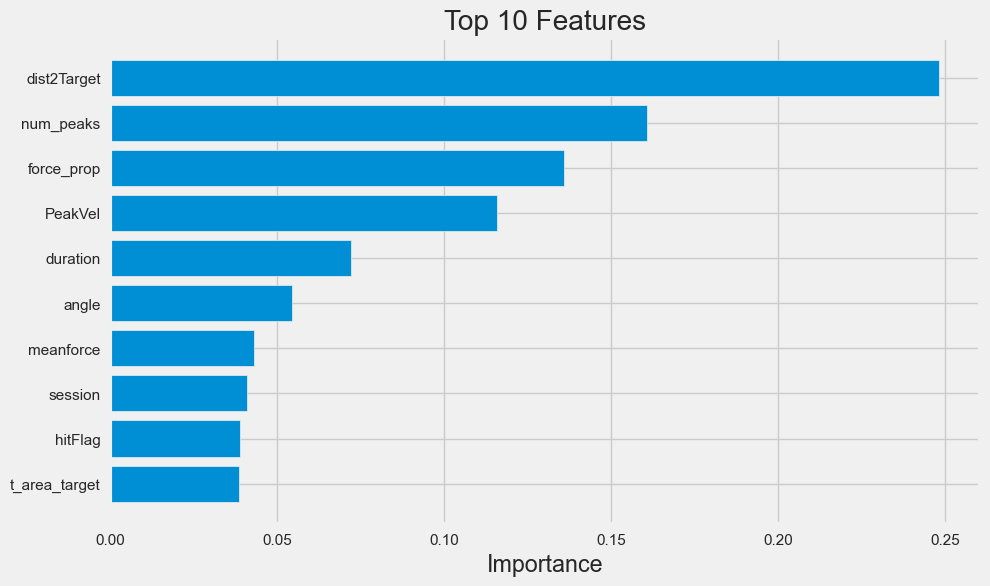

------------------- MT3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 17.82
Mean Absolute Error (MAE): 10.65
R-squared (R2): 0.68
       Feature      Importance
3      dist2Target   0.192666 
10      force_prop   0.166898 
7        num_peaks   0.117946 
9        meanforce   0.090800 
8         duration   0.085893 
6          PeakVel   0.079126 
5   t_pd200_target   0.065151 
4    t_area_target   0.063139 
0          session   0.043762 
11         hitFlag   0.041766 


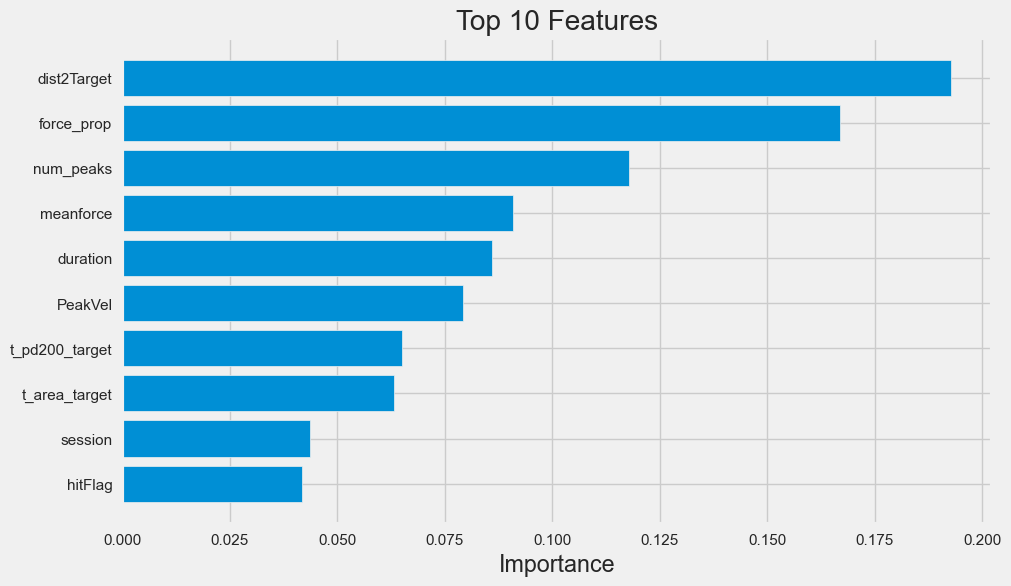

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 17.48
Mean Absolute Error (MAE): 10.95
R-squared (R2): 0.69
       Feature      Importance
3      dist2Target   0.260380 
7        num_peaks   0.168382 
10      force_prop   0.157775 
6          PeakVel   0.064603 
8         duration   0.058333 
5   t_pd200_target   0.051480 
2            angle   0.050012 
11         hitFlag   0.048826 
9        meanforce   0.045026 
4    t_area_target   0.041222 


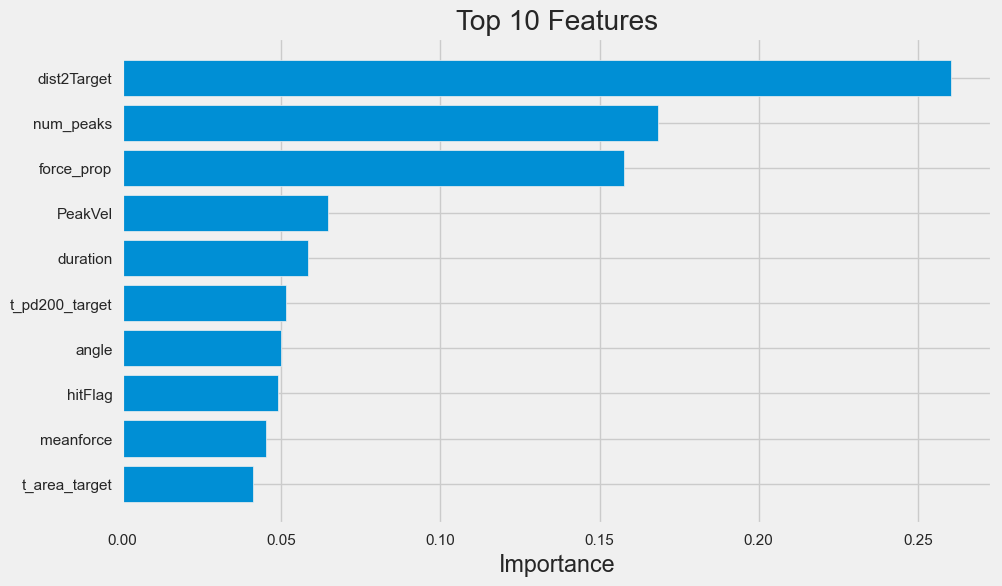

======================================== FAS ========================================
------------------- FAS1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.67
Mean Absolute Error (MAE): 0.41
R-squared (R2): 0.69
       Feature      Importance
3      dist2Target   0.217767 
10      force_prop   0.148222 
7        num_peaks   0.107304 
6          PeakVel   0.098435 
8         duration   0.096144 
9        meanforce   0.069063 
4    t_area_target   0.068899 
5   t_pd200_target   0.061358 
0          session   0.047640 
11         hitFlag   0.

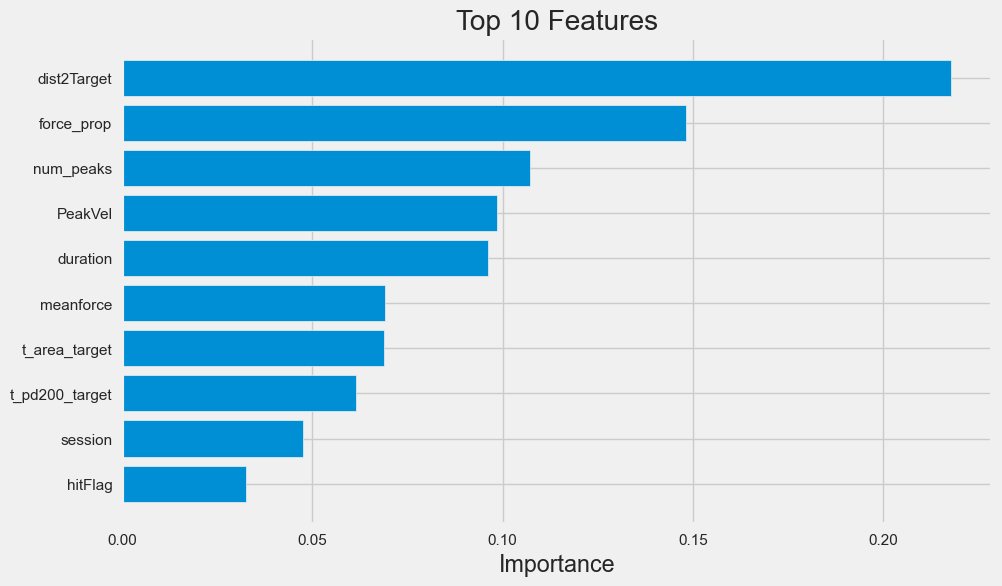

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.66
Mean Absolute Error (MAE): 0.42
R-squared (R2): 0.70
       Feature      Importance
3      dist2Target   0.261739 
7        num_peaks   0.179798 
10      force_prop   0.132977 
6          PeakVel   0.080400 
8         duration   0.078061 
11         hitFlag   0.052060 
2            angle   0.044924 
4    t_area_target   0.044118 
0          session   0.044094 
5   t_pd200_target   0.037576 


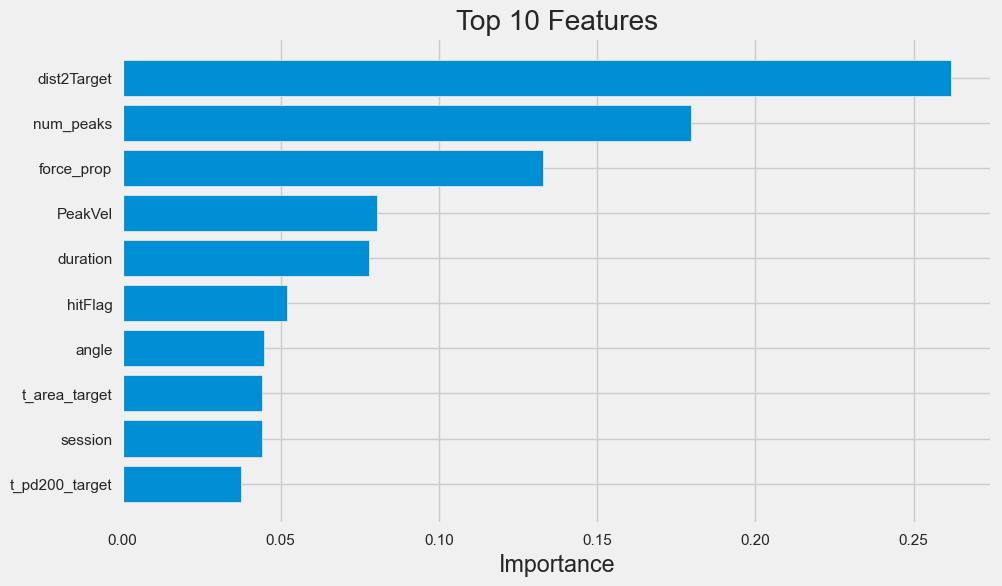

------------------- FAS2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.64
Mean Absolute Error (MAE): 0.39
R-squared (R2): 0.70
       Feature      Importance
3      dist2Target   0.211992 
10      force_prop   0.128899 
6          PeakVel   0.108436 
9        meanforce   0.102351 
7        num_peaks   0.099594 
8         duration   0.083232 
4    t_area_target   0.064061 
11         hitFlag   0.056161 
5   t_pd200_target   0.053565 
0          session   0.044521 


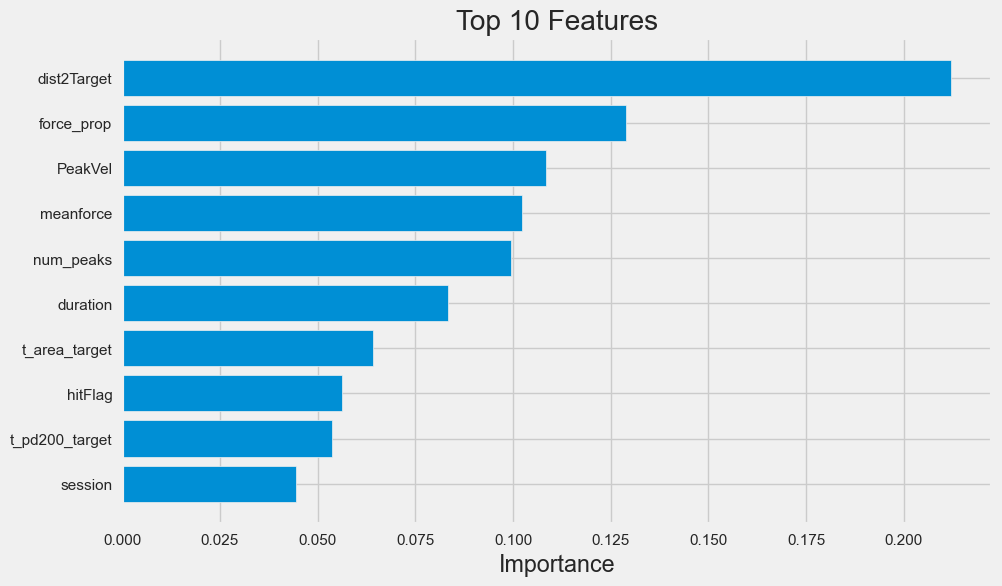

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.63
Mean Absolute Error (MAE): 0.40
R-squared (R2): 0.70
      Feature      Importance
3     dist2Target   0.265569 
7       num_peaks   0.157817 
9       meanforce   0.110107 
6         PeakVel   0.087046 
10     force_prop   0.083506 
8        duration   0.074653 
11        hitFlag   0.058569 
4   t_area_target   0.044761 
2           angle   0.041200 
0         session   0.038594 


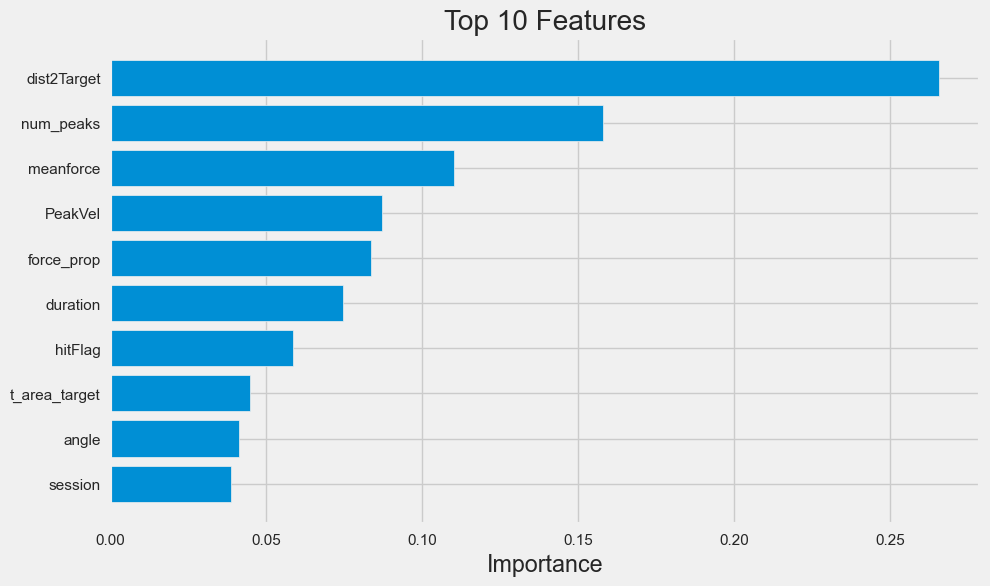

------------------- FAS3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.60
Mean Absolute Error (MAE): 0.37
R-squared (R2): 0.72
       Feature      Importance
3      dist2Target   0.209457 
10      force_prop   0.133740 
7        num_peaks   0.125437 
9        meanforce   0.109223 
6          PeakVel   0.097622 
8         duration   0.081902 
4    t_area_target   0.060452 
5   t_pd200_target   0.049882 
11         hitFlag   0.045589 
0          session   0.042712 


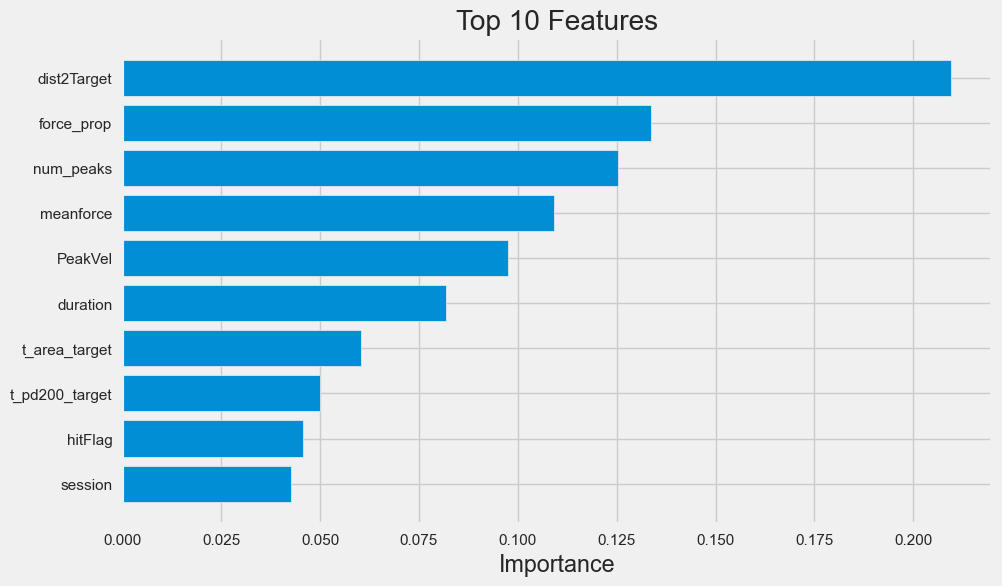

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.59
Mean Absolute Error (MAE): 0.38
R-squared (R2): 0.73
      Feature      Importance
3     dist2Target   0.236693 
7       num_peaks   0.200748 
9       meanforce   0.118395 
10     force_prop   0.109335 
6         PeakVel   0.079830 
8        duration   0.068166 
4   t_area_target   0.043641 
2           angle   0.039313 
0         session   0.035100 
11        hitFlag   0.032574 


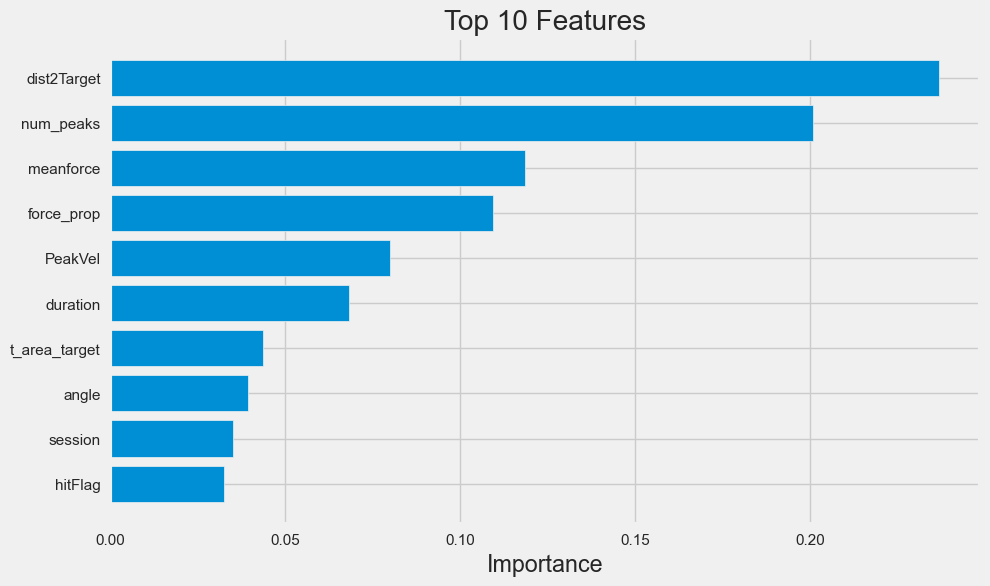

In [181]:
%matplotlib inline

for score_to_study in scores:
    print("======================================== " + score_to_study + " ========================================")
    data = study_score(raw, score_to_study)
    X_train, X_test, y_trainset, y_testset = train_test_split_data(data, score_to_study)
    for i in range(1,4):
        post_score = score_to_study + str(i)
        print("------------------- " + post_score + " -------------------")
        y_train = y_trainset[post_score]
        y_test = y_testset[post_score]
        best_rf_model, best_xgb_model = tune_hyperparameter(X_train, X_test, y_train, y_test)
        run_mode(X_train, X_test, y_train, y_test, best_rf_model, model = "rf")
        run_mode(X_train, X_test, y_train, y_test, best_xgb_model, model = "xgb")


# with RPE

In [ ]:
best_hyperparameter = collections.defaultdict()

In [201]:
def run_mode(X_train, X_test, y_train, y_test, best_param, model = "xgb"):
    if model == "xgb":
        print("RESULTS FOR XGBOOST REGRESSOR")
        # Create and train the XGBoostRegressor xgb
        model = XGBRegressor(**best_param, random_state=2023)
    if model == "rf":
        print("RESULTS FOR RANDOM FOREST REGRESSOR")
        # Create and train the XGBoostRegressor xgb
        model = RandomForestRegressor(**best_param, random_state=2023)

    # Specify the number of features to select
    n_features_to_select = 10  # Adjust this to the number of features you want to keep

    # Create the RFE model
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

    # Fit the RFE model to your data
    rfe.fit(X_train, y_train)

    # Get the ranking of features (1 indicates selected, 0 indicates not selected)
    feature_ranking = rfe.ranking_

    # Get the mask of selected features (True for selected, False for not selected)
    selected_features = rfe.support_

    # List the selected features
    selected_feature_names = X.columns[selected_features]
    print("Selected Features:")
    print(selected_feature_names)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate various regression metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    # same units as the target variable
    # RMSE = (MSE)^1/2
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

    # MAE measures the average absolute difference between predicted values and actual 
    # MAE = (1/n) * Σ|y_true - y_pred|
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # a statistical metric used to measure the goodness of fit of a regression model
    print(f"R-squared (R2): {r2:.2f}")
    
    # Get feature importance scores
    feature_importance = model.feature_importances_

    # Create a DataFrame to display feature names and their importance scores
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

    # Sort the DataFrame by importance scores in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the top 10 features
    top_10_features = feature_importance_df.head(10)
    print(top_10_features)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features['Feature'], top_10_features['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Features')
    plt.gca().invert_yaxis()
    plt.show()

======================================== FMA ========================================
------------------- FMA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.51
Mean Absolute Error (MAE): 6.32
R-squared (R2): 0.67
           Feature  Importance
3      dist2Target    0.208735
10      force_prop    0.135993
6          PeakVel    0.119976
7        num_peaks    0.100195
8         duration    0.091806
9        meanforce    0.074381
4    t_area_target    0.070808
5   t_pd200_target    0.060845
0          session    0.049185
11         hitFlag    

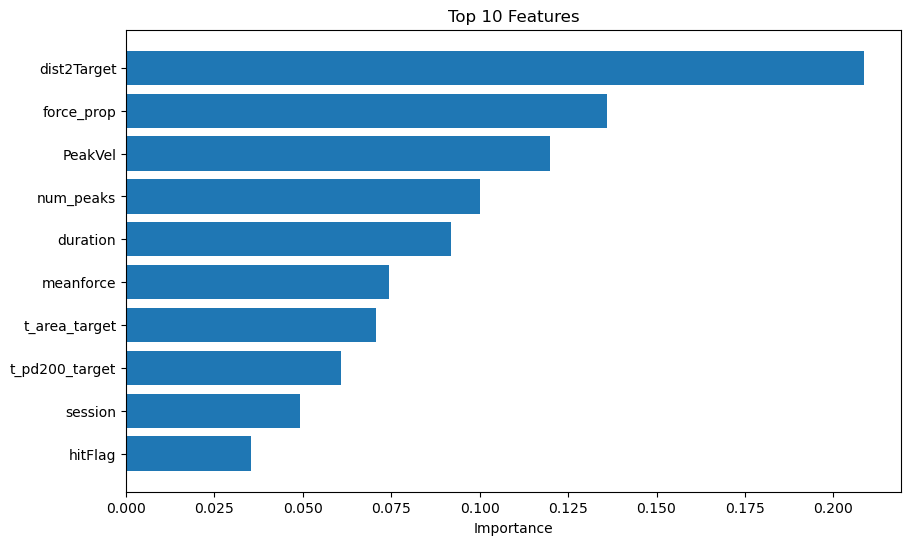

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.39
Mean Absolute Error (MAE): 6.47
R-squared (R2): 0.68
          Feature  Importance
3     dist2Target    0.249746
7       num_peaks    0.191469
10     force_prop    0.117731
6         PeakVel    0.112655
8        duration    0.070197
4   t_area_target    0.045573
11        hitFlag    0.045198
9       meanforce    0.045065
2           angle    0.042203
0         session    0.039744


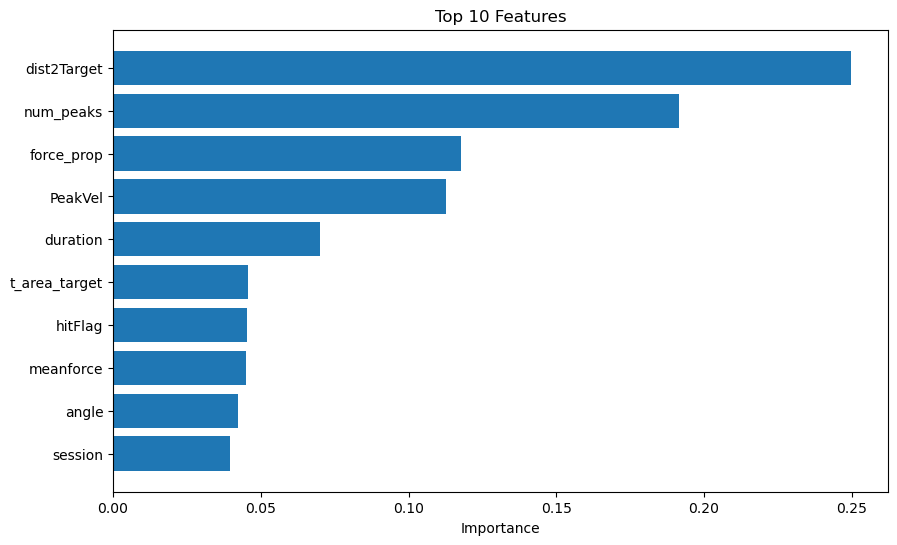

------------------- FMA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.27
Mean Absolute Error (MAE): 6.12
R-squared (R2): 0.68
           Feature  Importance
3      dist2Target    0.215493
10      force_prop    0.136560
6          PeakVel    0.117127
7        num_peaks    0.092804
8         duration    0.089650
9        meanforce    0.077078
4    t_area_target    0.071113
5   t_pd200_target    0.062589
0          session    0.049791
11         hitFlag    0.035587


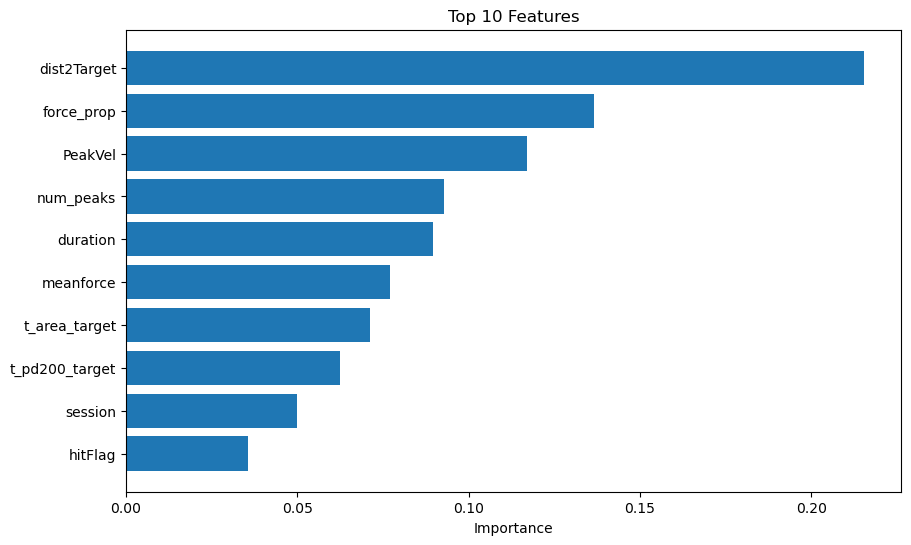

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.21
Mean Absolute Error (MAE): 6.34
R-squared (R2): 0.68
          Feature  Importance
3     dist2Target    0.238760
7       num_peaks    0.173194
10     force_prop    0.115533
6         PeakVel    0.113913
11        hitFlag    0.055861
8        duration    0.055140
9       meanforce    0.054485
2           angle    0.048686
0         session    0.046271
4   t_area_target    0.044084


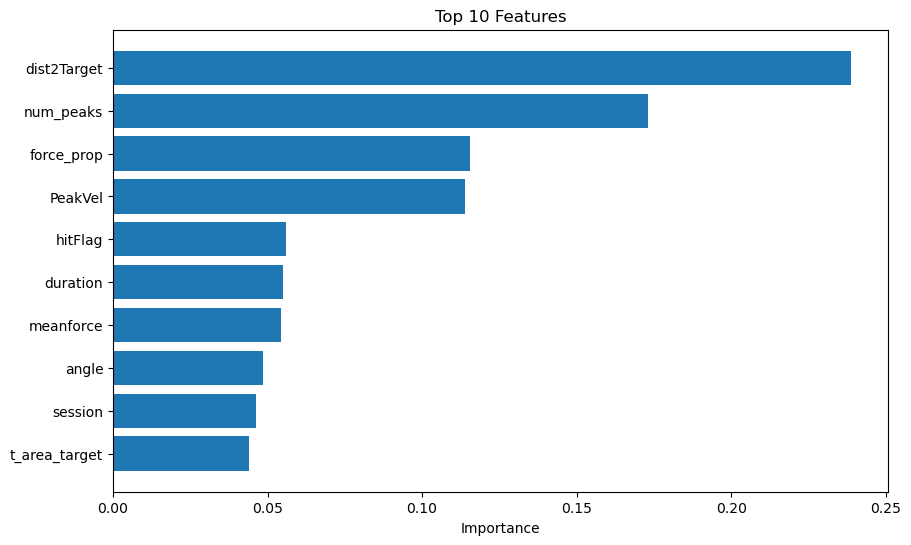

------------------- FMA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 10.02
Mean Absolute Error (MAE): 5.91
R-squared (R2): 0.67
           Feature  Importance
3      dist2Target    0.227425
10      force_prop    0.134411
6          PeakVel    0.105385
7        num_peaks    0.096237
9        meanforce    0.081845
8         duration    0.081411
4    t_area_target    0.068754
5   t_pd200_target    0.058906
0          session    0.047872
11         hitFlag    0.047640


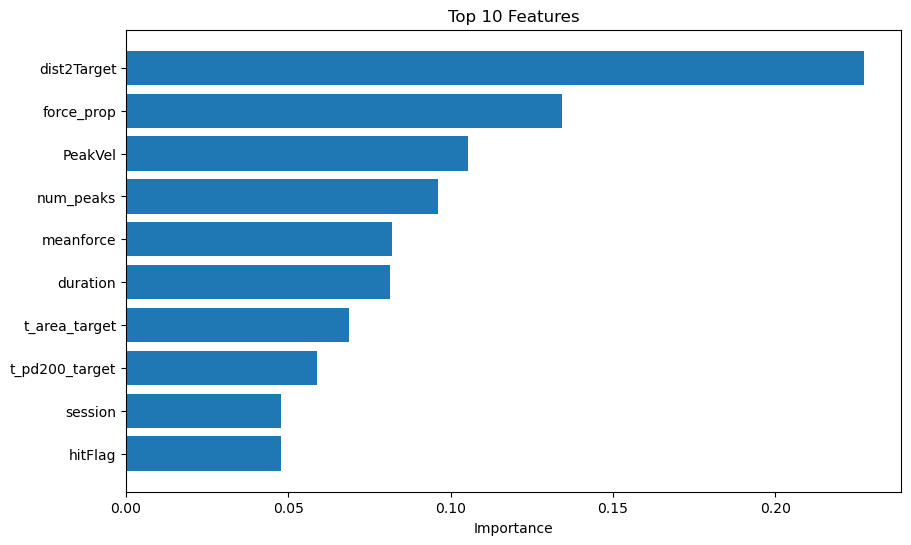

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 10.00
Mean Absolute Error (MAE): 6.15
R-squared (R2): 0.67
          Feature  Importance
3     dist2Target    0.255549
7       num_peaks    0.161713
10     force_prop    0.110926
6         PeakVel    0.099553
9       meanforce    0.063725
11        hitFlag    0.063327
8        duration    0.060732
4   t_area_target    0.051102
2           angle    0.046486
0         session    0.043930


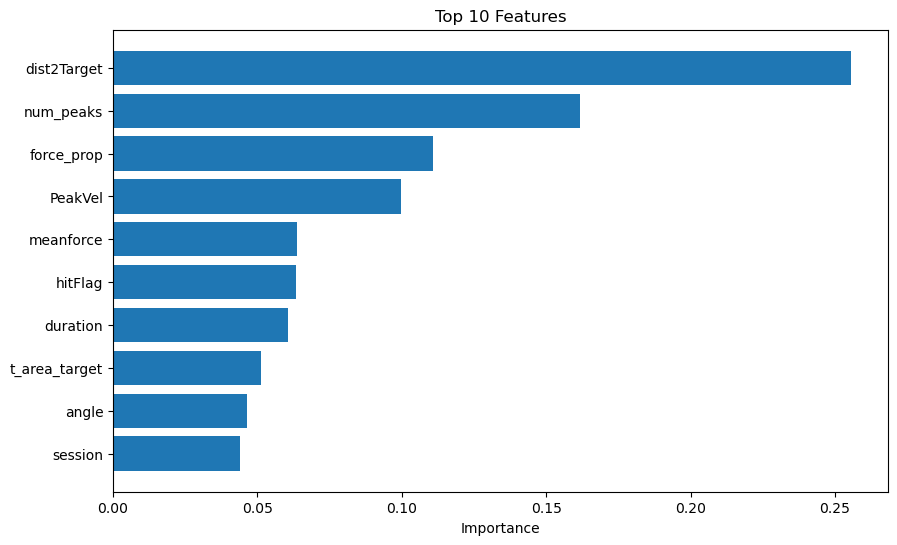

======================================== NSA ========================================
------------------- NSA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.96
Mean Absolute Error (MAE): 4.18
R-squared (R2): 0.66
           Feature  Importance
10      force_prop    0.154034
9        meanforce    0.127387
6          PeakVel    0.121788
7        num_peaks    0.114594
8         duration    0.106271
3      dist2Target    0.086367
4    t_area_target    0.080512
5   t_pd200_target    0.070028
0          session    0.055123
2            angle    0

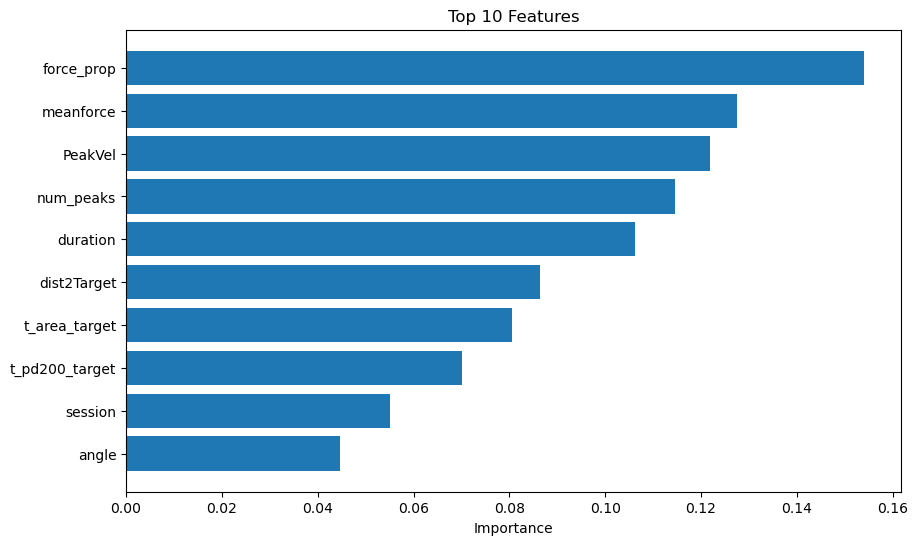

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 6.04
Mean Absolute Error (MAE): 4.30
R-squared (R2): 0.65
          Feature  Importance
11        hitFlag    0.338765
7       num_peaks    0.127826
9       meanforce    0.104717
8        duration    0.076497
10     force_prop    0.075269
6         PeakVel    0.062620
2           angle    0.058747
3     dist2Target    0.047593
0         session    0.040996
4   t_area_target    0.032242


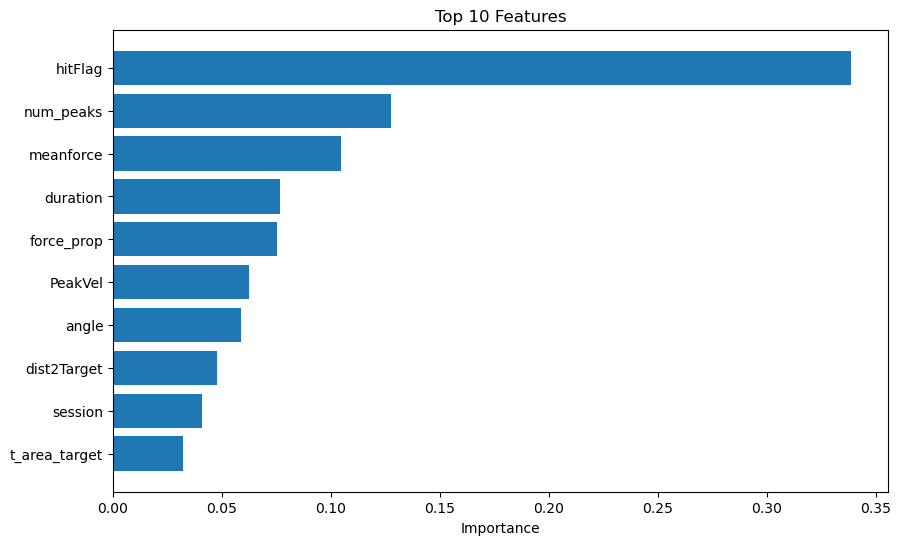

------------------- NSA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.51
Mean Absolute Error (MAE): 3.75
R-squared (R2): 0.75
           Feature  Importance
9        meanforce    0.183027
10      force_prop    0.154726
6          PeakVel    0.144444
3      dist2Target    0.095385
8         duration    0.089708
7        num_peaks    0.082753
4    t_area_target    0.064866
5   t_pd200_target    0.057526
0          session    0.045134
2            angle    0.039063


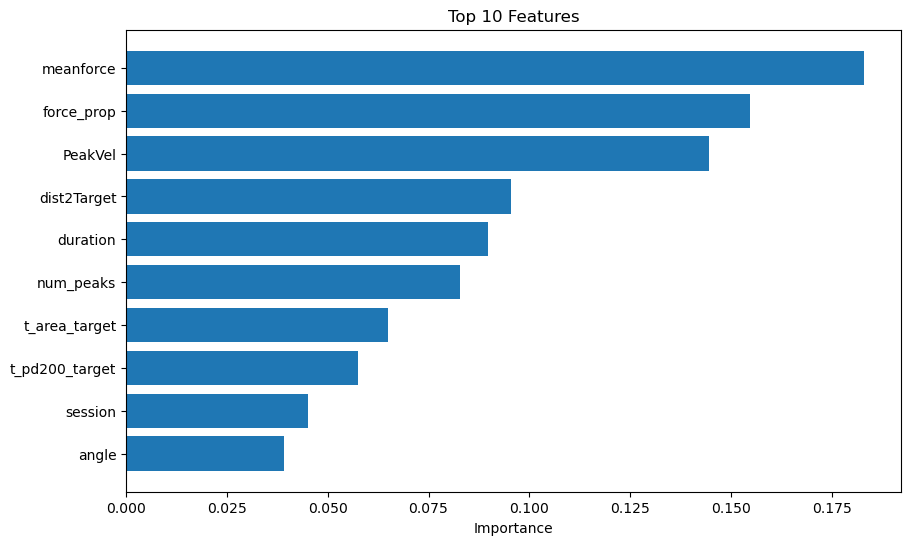

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 5.61
Mean Absolute Error (MAE): 3.92
R-squared (R2): 0.74
          Feature  Importance
11        hitFlag    0.420591
9       meanforce    0.197319
7       num_peaks    0.078444
6         PeakVel    0.067417
8        duration    0.050180
3     dist2Target    0.046253
2           angle    0.037252
10     force_prop    0.035812
0         session    0.026678
4   t_area_target    0.018870


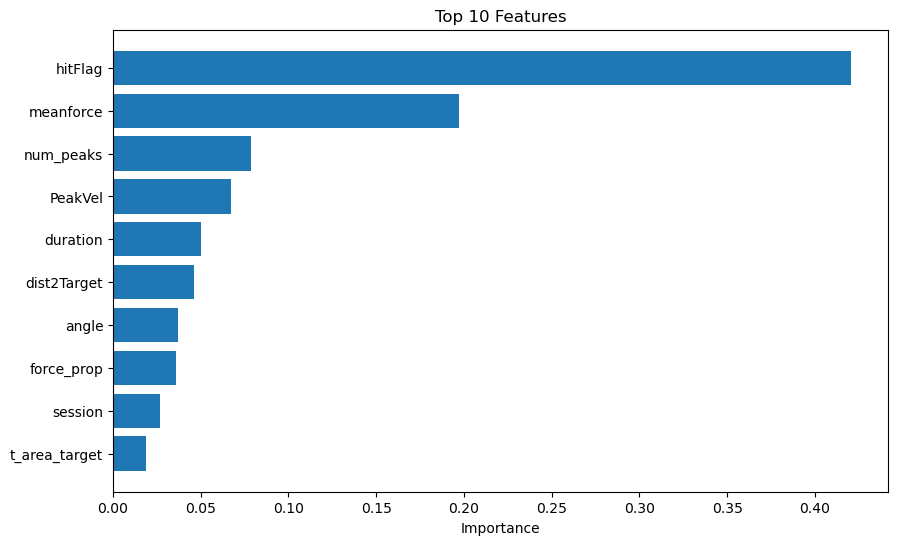

------------------- NSA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 5.91
Mean Absolute Error (MAE): 3.94
R-squared (R2): 0.72
           Feature  Importance
9        meanforce    0.163267
6          PeakVel    0.151327
10      force_prop    0.147184
8         duration    0.097257
7        num_peaks    0.090595
3      dist2Target    0.086094
4    t_area_target    0.066304
5   t_pd200_target    0.061070
0          session    0.049260
2            angle    0.043981


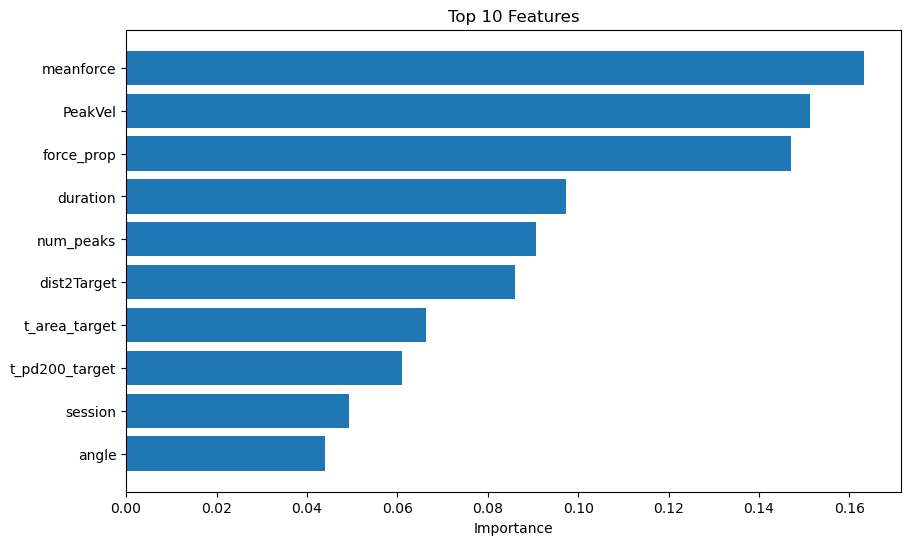

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 6.01
Mean Absolute Error (MAE): 4.13
R-squared (R2): 0.71
          Feature  Importance
11        hitFlag    0.399203
9       meanforce    0.137771
7       num_peaks    0.110555
8        duration    0.074671
6         PeakVel    0.069710
10     force_prop    0.041935
2           angle    0.041642
3     dist2Target    0.040969
0         session    0.035800
4   t_area_target    0.023392


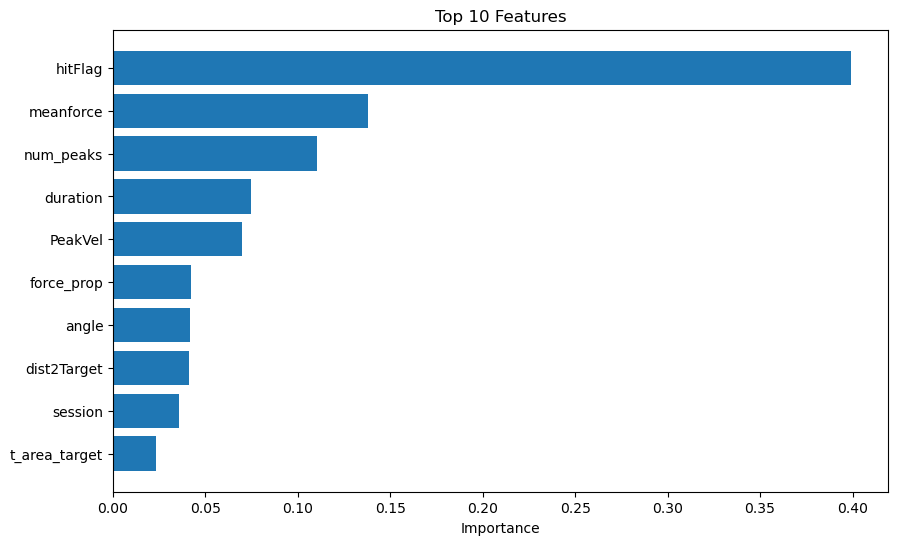

======================================== MT ========================================
------------------- MT1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 18.05
Mean Absolute Error (MAE): 11.59
R-squared (R2): 0.68
           Feature  Importance
3      dist2Target    0.167983
10      force_prop    0.162170
6          PeakVel    0.115189
7        num_peaks    0.114177
8         duration    0.098988
9        meanforce    0.080544
4    t_area_target    0.067735
5   t_pd200_target    0.061100
0          session    0.047100
2            angl

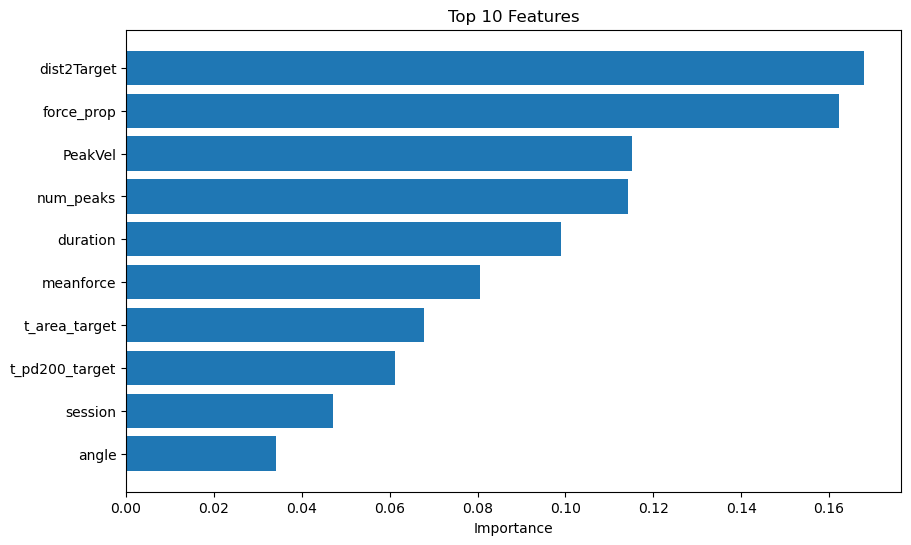

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 17.77
Mean Absolute Error (MAE): 11.72
R-squared (R2): 0.69
           Feature  Importance
3      dist2Target    0.196631
7        num_peaks    0.181351
10      force_prop    0.141201
6          PeakVel    0.116510
8         duration    0.097247
2            angle    0.060111
0          session    0.044265
5   t_pd200_target    0.039596
11         hitFlag    0.038737
9        meanforce    0.038529


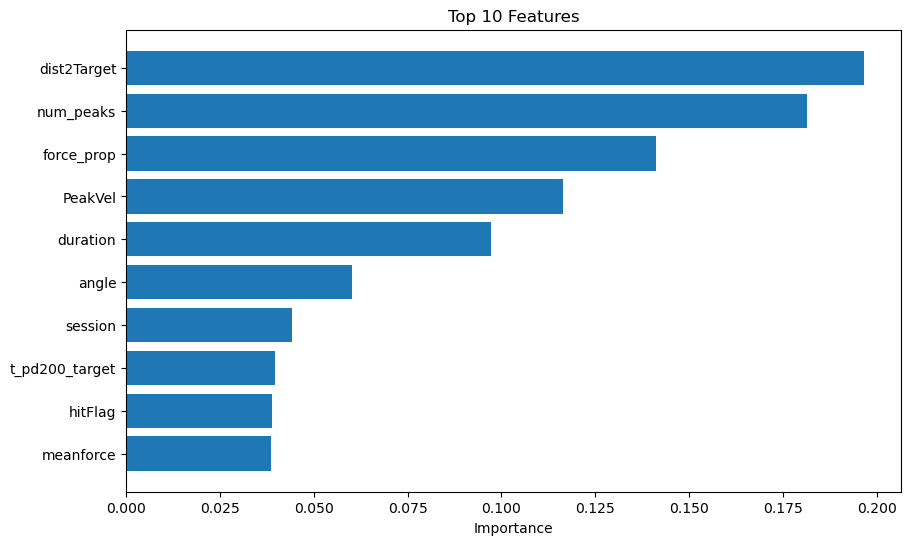

------------------- MT2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 16.14
Mean Absolute Error (MAE): 9.81
R-squared (R2): 0.68
           Feature  Importance
3      dist2Target    0.184217
10      force_prop    0.145993
7        num_peaks    0.110094
6          PeakVel    0.099478
9        meanforce    0.095896
8         duration    0.089377
4    t_area_target    0.068300
5   t_pd200_target    0.062071
0          session    0.046383
11         hitFlag    0.042958


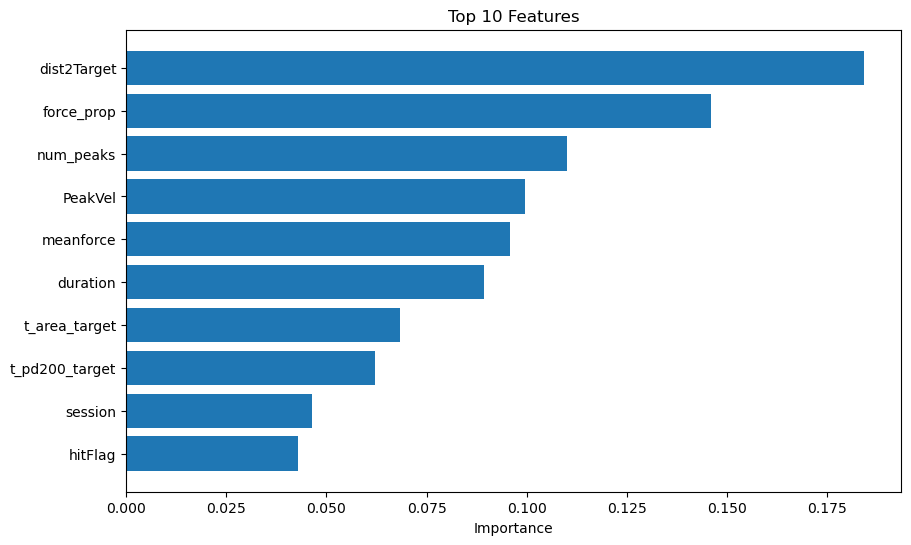

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 16.05
Mean Absolute Error (MAE): 10.21
R-squared (R2): 0.68
          Feature  Importance
3     dist2Target    0.248150
7       num_peaks    0.160730
10     force_prop    0.135878
6         PeakVel    0.115722
8        duration    0.071988
2           angle    0.054494
9       meanforce    0.043084
0         session    0.040838
11        hitFlag    0.038910
4   t_area_target    0.038669


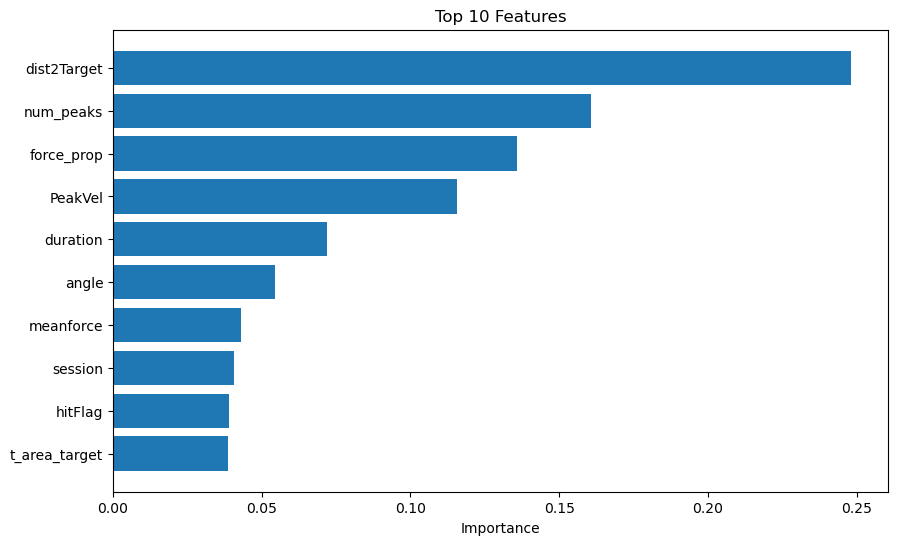

------------------- MT3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 17.82
Mean Absolute Error (MAE): 10.65
R-squared (R2): 0.68
           Feature  Importance
3      dist2Target    0.192666
10      force_prop    0.166898
7        num_peaks    0.117946
9        meanforce    0.090800
8         duration    0.085893
6          PeakVel    0.079126
5   t_pd200_target    0.065151
4    t_area_target    0.063139
0          session    0.043762
11         hitFlag    0.041766


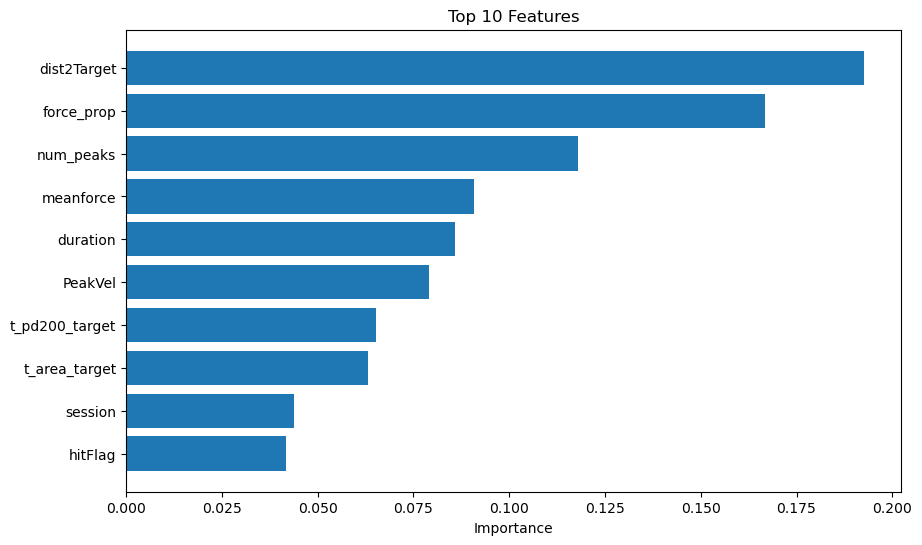

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 17.48
Mean Absolute Error (MAE): 10.95
R-squared (R2): 0.69
           Feature  Importance
3      dist2Target    0.260380
7        num_peaks    0.168382
10      force_prop    0.157775
6          PeakVel    0.064603
8         duration    0.058333
5   t_pd200_target    0.051480
2            angle    0.050012
11         hitFlag    0.048826
9        meanforce    0.045026
4    t_area_target    0.041222


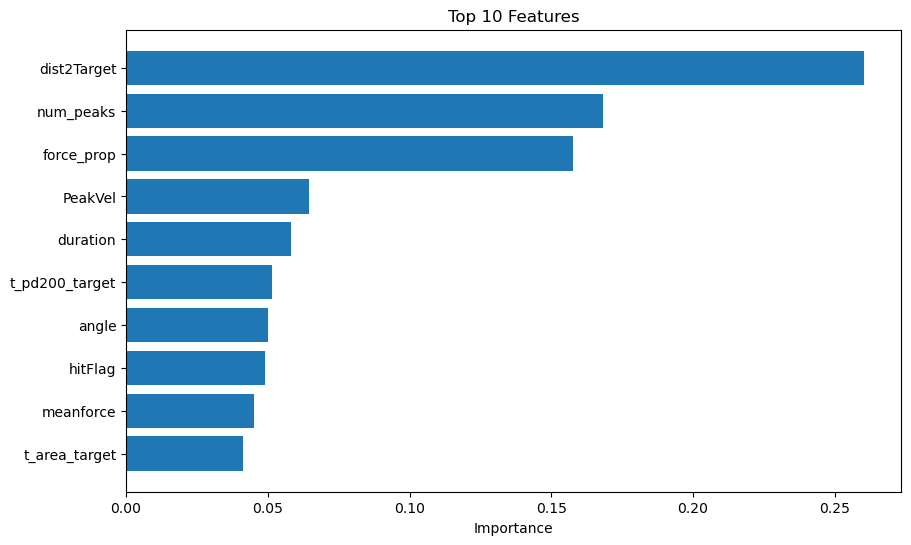

======================================== FAS ========================================
------------------- FAS1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.67
Mean Absolute Error (MAE): 0.41
R-squared (R2): 0.69
           Feature  Importance
3      dist2Target    0.217767
10      force_prop    0.148222
7        num_peaks    0.107304
6          PeakVel    0.098435
8         duration    0.096144
9        meanforce    0.069063
4    t_area_target    0.068899
5   t_pd200_target    0.061358
0          session    0.047640
11         hitFlag    0

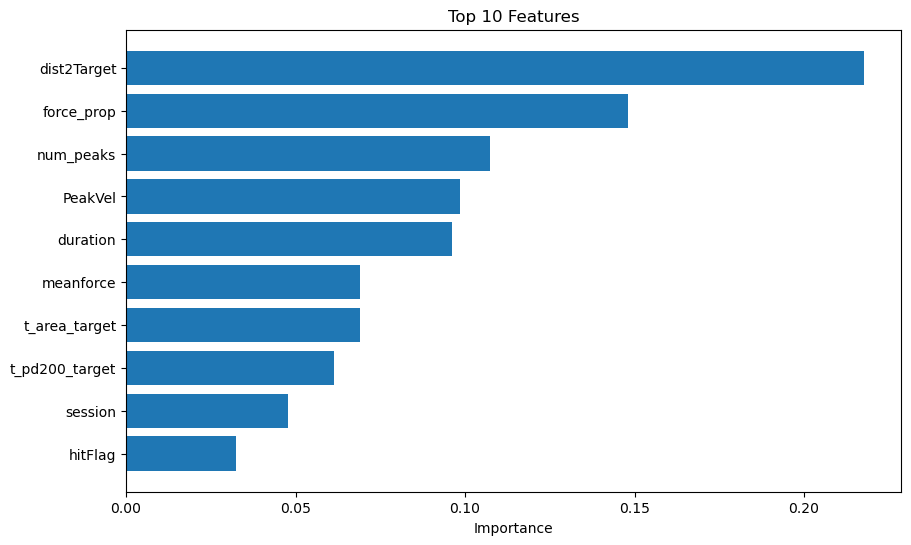

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.66
Mean Absolute Error (MAE): 0.42
R-squared (R2): 0.70
           Feature  Importance
3      dist2Target    0.261739
7        num_peaks    0.179798
10      force_prop    0.132977
6          PeakVel    0.080400
8         duration    0.078061
11         hitFlag    0.052060
2            angle    0.044924
4    t_area_target    0.044118
0          session    0.044094
5   t_pd200_target    0.037576


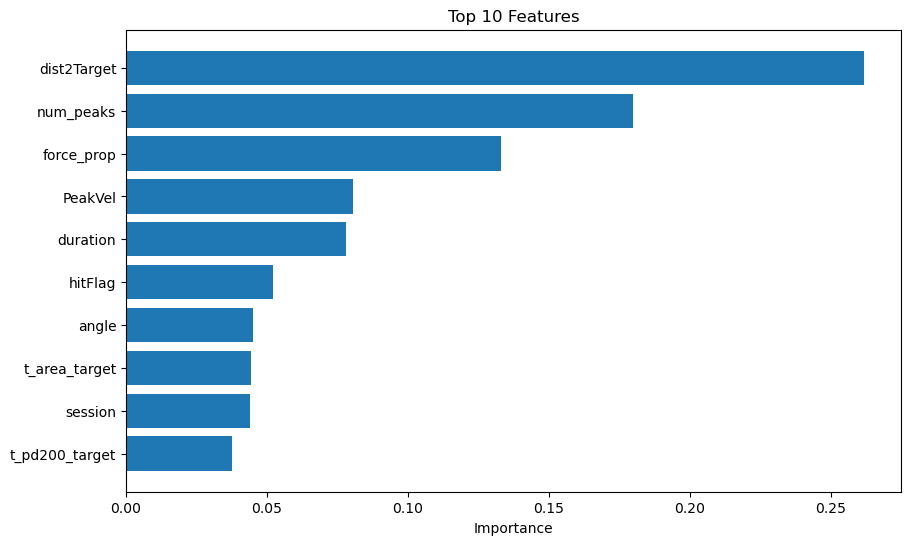

------------------- FAS2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.64
Mean Absolute Error (MAE): 0.39
R-squared (R2): 0.70
           Feature  Importance
3      dist2Target    0.211992
10      force_prop    0.128899
6          PeakVel    0.108436
9        meanforce    0.102351
7        num_peaks    0.099594
8         duration    0.083232
4    t_area_target    0.064061
11         hitFlag    0.056161
5   t_pd200_target    0.053565
0          session    0.044521


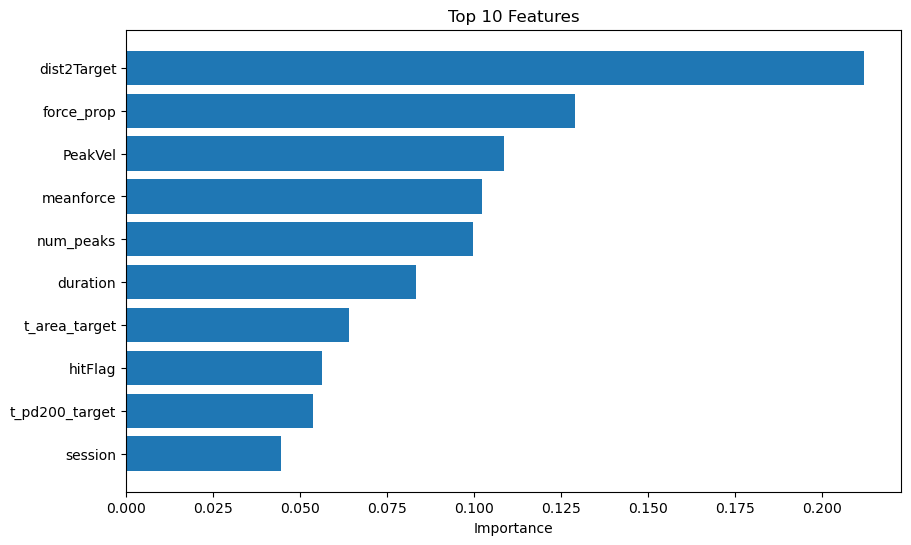

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.63
Mean Absolute Error (MAE): 0.40
R-squared (R2): 0.70
          Feature  Importance
3     dist2Target    0.265569
7       num_peaks    0.157817
9       meanforce    0.110107
6         PeakVel    0.087046
10     force_prop    0.083506
8        duration    0.074653
11        hitFlag    0.058569
4   t_area_target    0.044761
2           angle    0.041200
0         session    0.038594


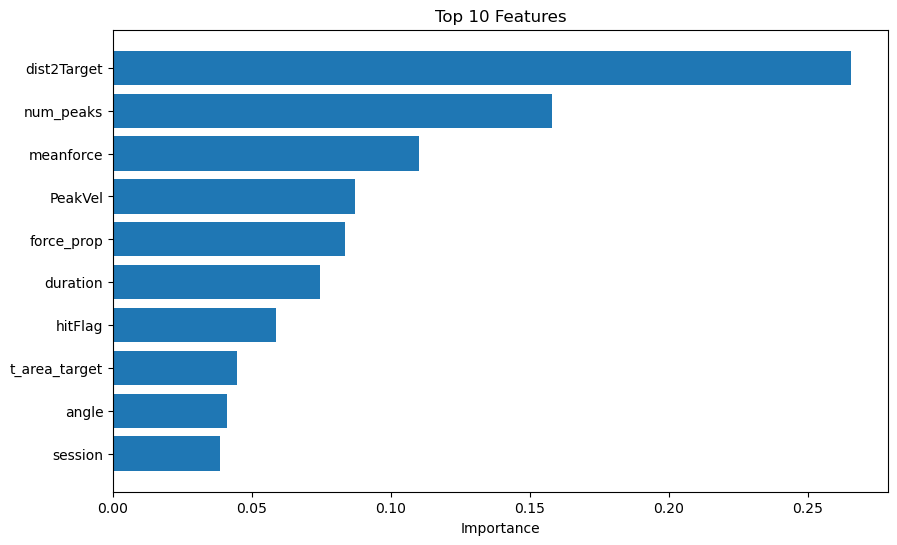

------------------- FAS3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.60
Mean Absolute Error (MAE): 0.37
R-squared (R2): 0.72
           Feature  Importance
3      dist2Target    0.209457
10      force_prop    0.133740
7        num_peaks    0.125437
9        meanforce    0.109223
6          PeakVel    0.097622
8         duration    0.081902
4    t_area_target    0.060452
5   t_pd200_target    0.049882
11         hitFlag    0.045589
0          session    0.042712


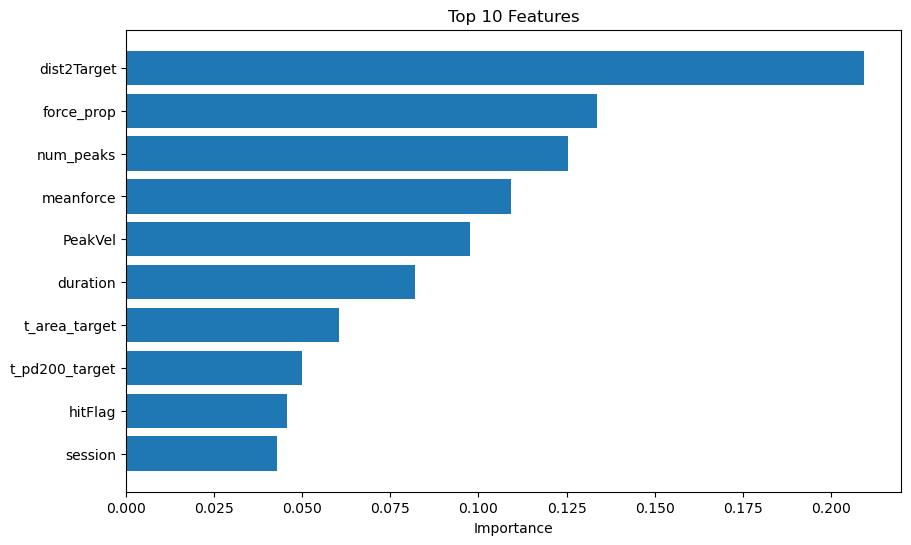

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 0.59
Mean Absolute Error (MAE): 0.38
R-squared (R2): 0.73
          Feature  Importance
3     dist2Target    0.236693
7       num_peaks    0.200748
9       meanforce    0.118395
10     force_prop    0.109335
6         PeakVel    0.079830
8        duration    0.068166
4   t_area_target    0.043641
2           angle    0.039313
0         session    0.035100
11        hitFlag    0.032574


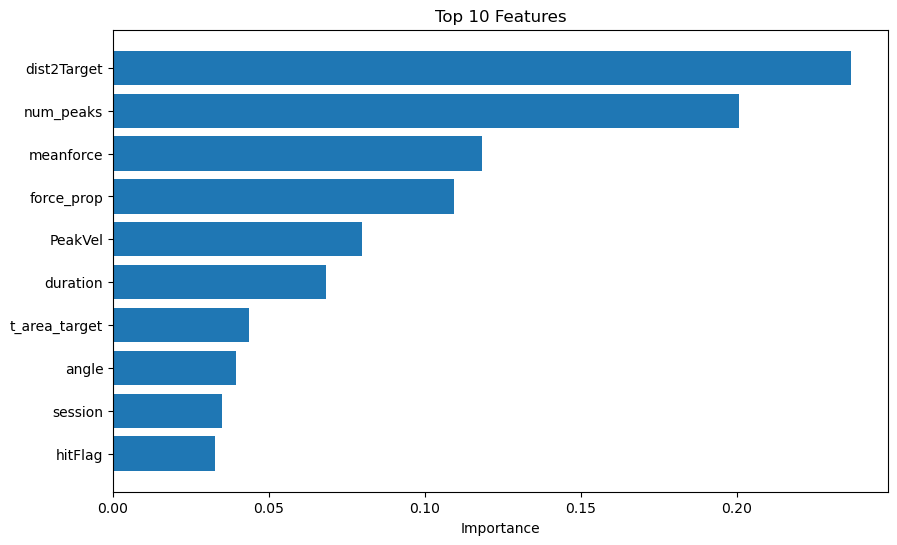

In [11]:
%matplotlib inline
best_hyperparameter = collections.defaultdict()
for score_to_study in scores:
    print("======================================== " + score_to_study + " ========================================")
    data = study_score(raw, score_to_study)
    X_train, X_test, y_trainset, y_testset = train_test_split_data(data, score_to_study)
    for i in range(1,4):
        post_score = score_to_study + str(i)
        print("------------------- " + post_score + " -------------------")
        y_train = y_trainset[post_score]
        y_test = y_testset[post_score]
        best_rf_model, best_xgb_model = tune_hyperparameter(X_train, X_test, y_train, y_test)
        best_hyperparameter[post_score +"_rf"] = best_rf_model
        best_hyperparameter[post_score + "_xgb"] = best_xgb_model
        run_mode(X_train, X_test, y_train, y_test, best_rf_model, model = "rf")
        run_mode(X_train, X_test, y_train, y_test, best_xgb_model, model = "xgb")


# using derived formula only

In [192]:
raw = pd.read_csv("Z:\DataCollection\ActiveSensorimotorTrainingForChronicStroke(RFP)\Processed Data\scores_forAnna.csv")
raw.drop(["subject", "Unnamed: 0"], axis = 1, inplace=True)


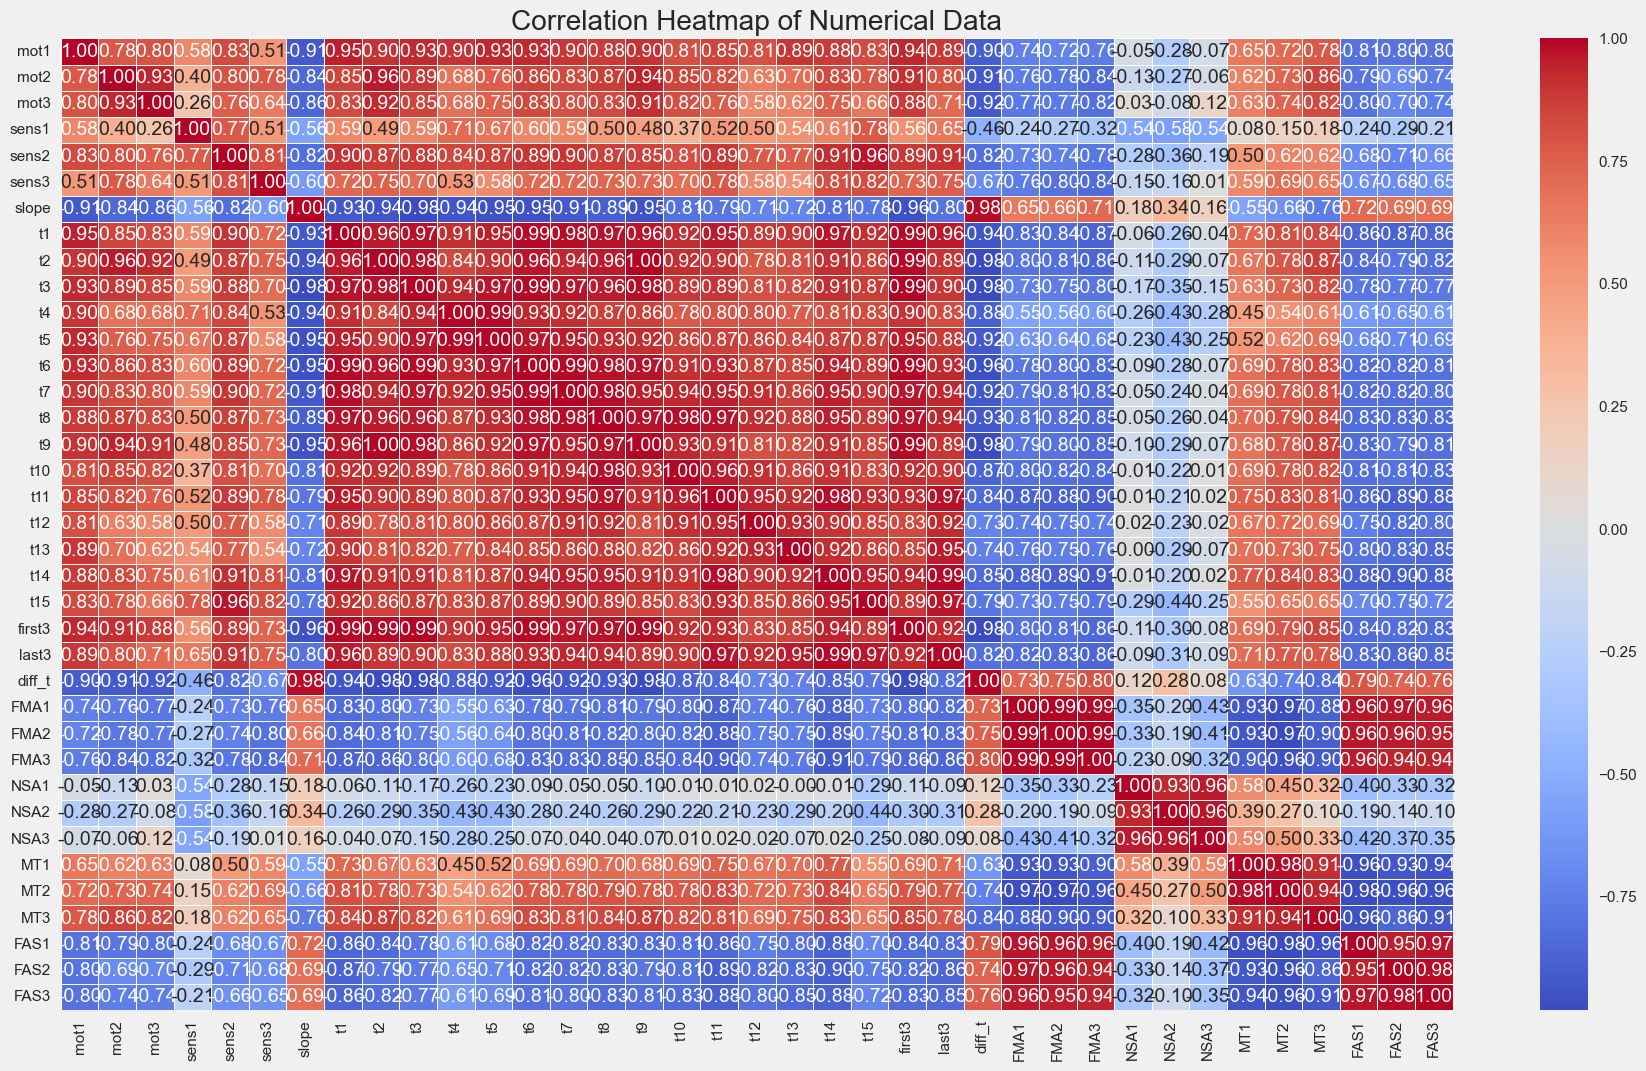

In [193]:
%matplotlib inline
# check for collinearity
numerical_df = raw.select_dtypes(include=["number"])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Data')
plt.show()

======================================== FMA ========================================
------------------- FMA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 18.65
Mean Absolute Error (MAE): 15.51
R-squared (R2): 0.28
   Feature  Importance
19     t13   0.106555 
1     mot2   0.090485 
15      t9   0.069171 
5    sens3   0.067178 
10      t4   0.058673 
18     t12   0.047905 
2     mot3   0.047838 
3    sens1   0.047785 
8       t2   0.044688 
23   last3   0.042496 


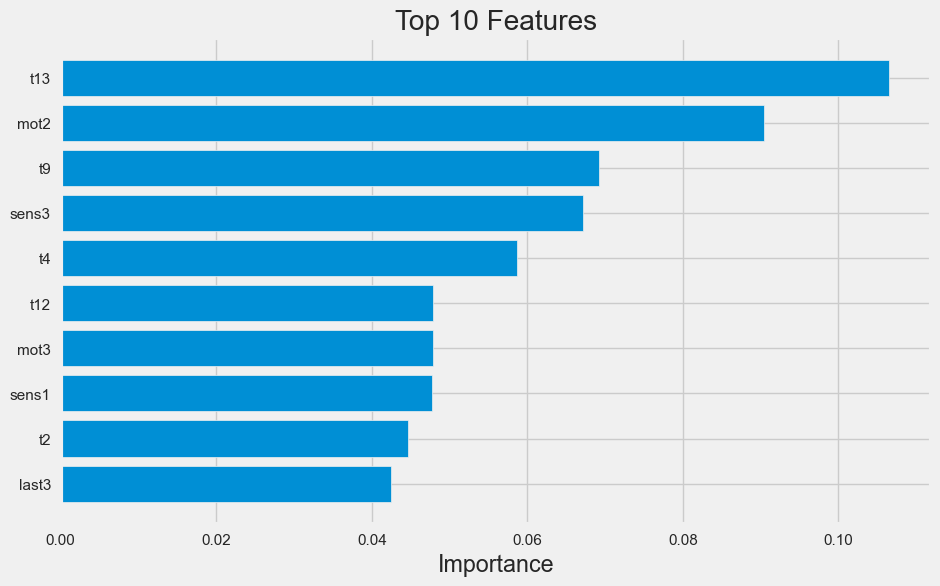

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 26.44
Mean Absolute Error (MAE): 20.65
R-squared (R2): -0.44
   Feature  Importance
1     mot2   0.311095 
5    sens3   0.215118 
16     t10   0.173191 
0     mot1   0.127642 
2     mot3   0.120333 
6    slope   0.048294 
4    sens2   0.001437 
3    sens1   0.001305 
13      t7   0.000810 
14      t8   0.000774 


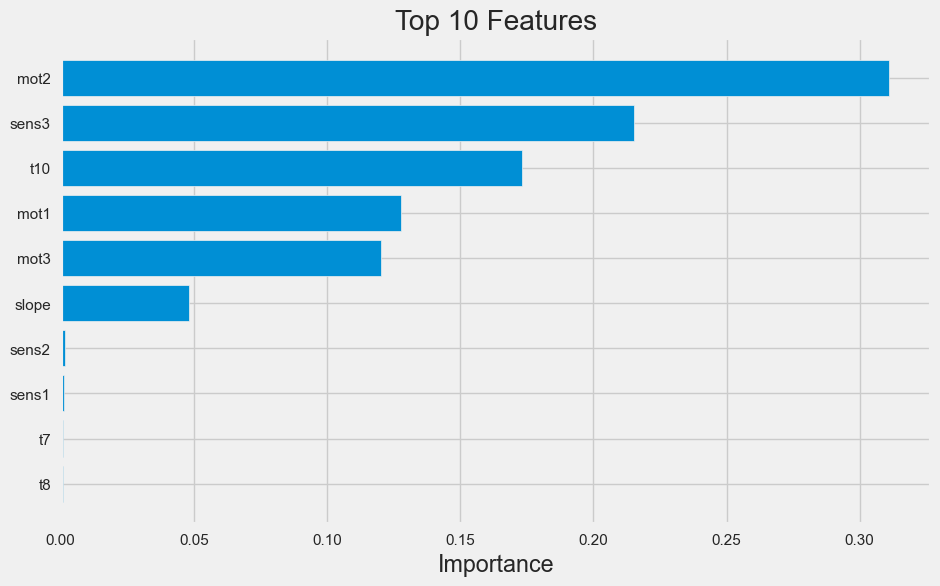

------------------- FMA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 19.18
Mean Absolute Error (MAE): 16.88
R-squared (R2): 0.17
   Feature  Importance
19     t13   0.118644 
5    sens3   0.110169 
1     mot2   0.084746 
2     mot3   0.059322 
12      t6   0.050847 
15      t9   0.050847 
24  diff_t   0.050847 
10      t4   0.042373 
23   last3   0.042373 
8       t2   0.042373 


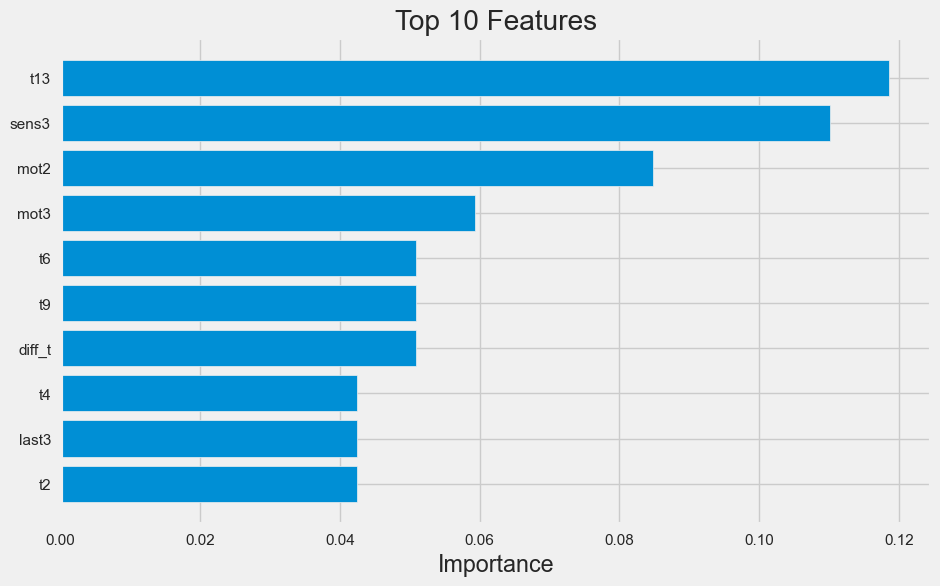

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 24.78
Mean Absolute Error (MAE): 18.35
R-squared (R2): -0.39
   Feature  Importance
0     mot1   0.994451 
1     mot2   0.005549 
13      t7   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 
18     t12   0.000000 
17     t11   0.000000 


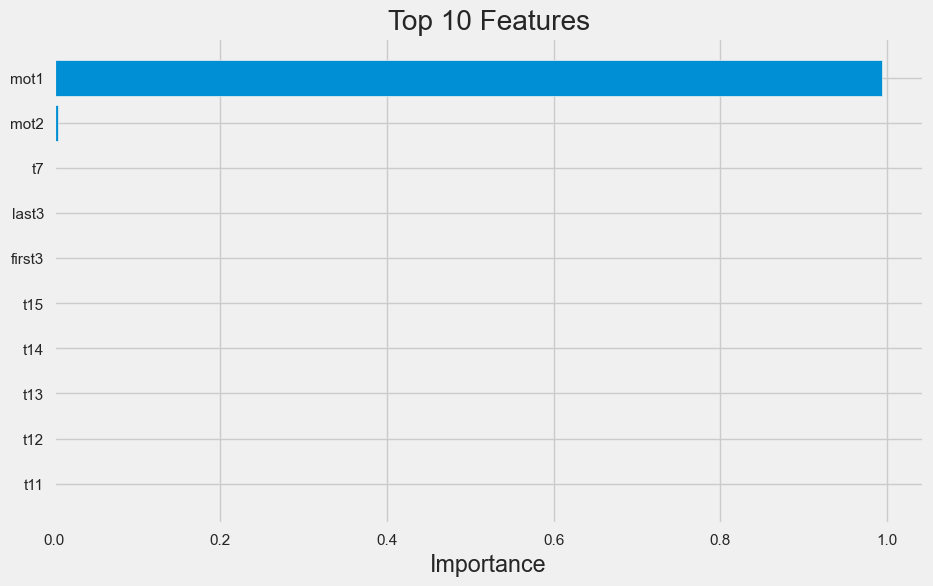

------------------- FMA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 12.79
Mean Absolute Error (MAE): 10.60
R-squared (R2): 0.47
   Feature  Importance
19     t13   0.100844 
1     mot2   0.091559 
5    sens3   0.083295 
3    sens1   0.053443 
18     t12   0.051882 
10      t4   0.048422 
12      t6   0.046185 
8       t2   0.044986 
23   last3   0.043083 
15      t9   0.042615 


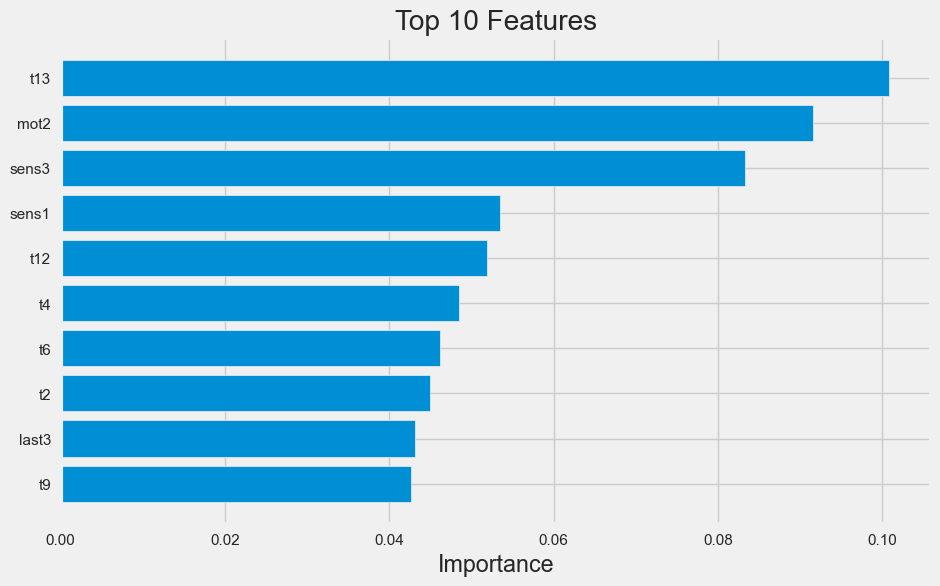

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 21.60
Mean Absolute Error (MAE): 15.77
R-squared (R2): -0.52
   Feature  Importance
0     mot1   0.981607 
1     mot2   0.018393 
13      t7   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 
18     t12   0.000000 
17     t11   0.000000 


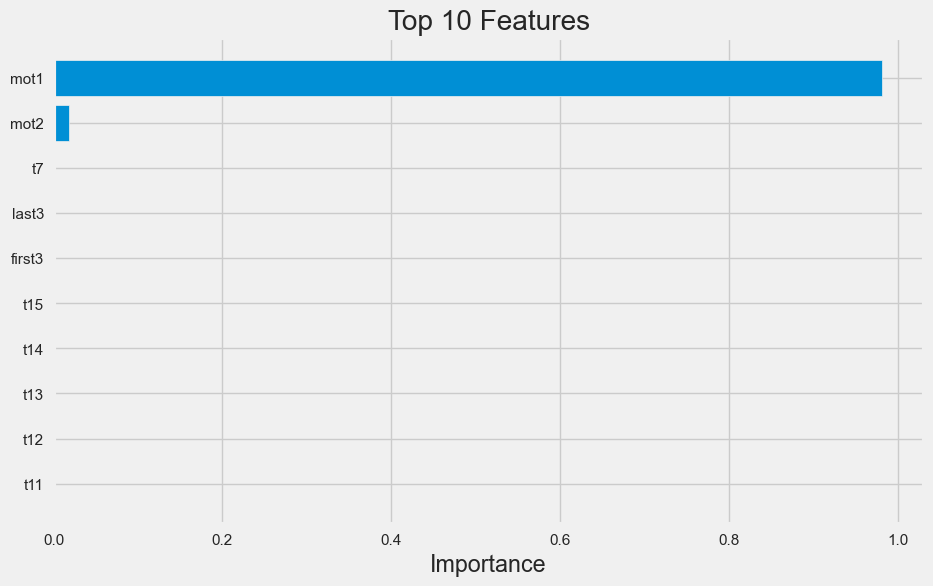

======================================== NSA ========================================
------------------- NSA1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 19.48
Mean Absolute Error (MAE): 18.50
R-squared (R2): -0.94
   Feature  Importance
21     t15   0.118329 
4    sens2   0.113945 
20     t14   0.086957 
5    sens3   0.074944 
3    sens1   0.065524 
11      t5   0.054348 
17     t11   0.052953 
1     mot2   0.049099 
19     t13   0.044422 
9       t3   0.043478 


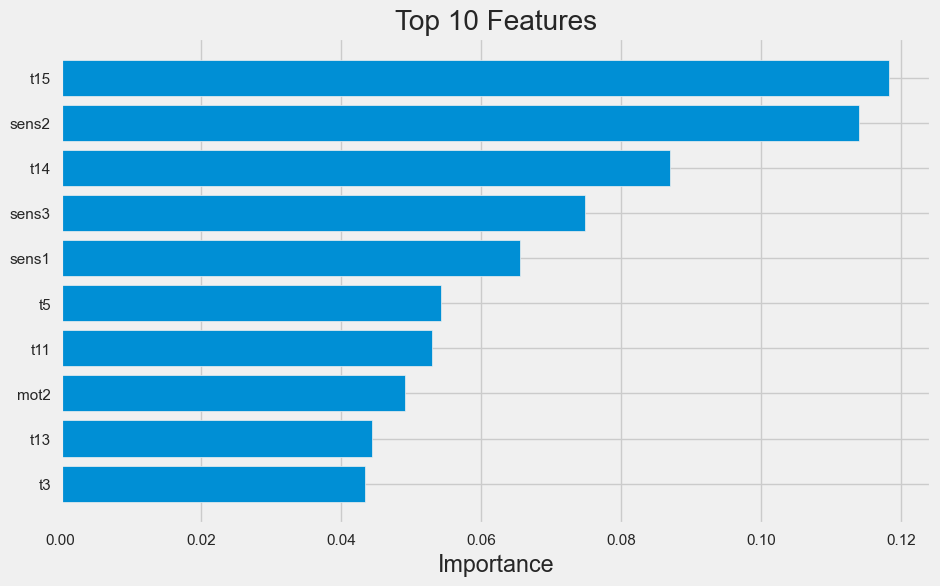

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 16.58
Mean Absolute Error (MAE): 16.18
R-squared (R2): -0.40
   Feature  Importance
3    sens1   0.573117 
4    sens2   0.367626 
16     t10   0.059257 
0     mot1   0.000000 
14      t8   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 


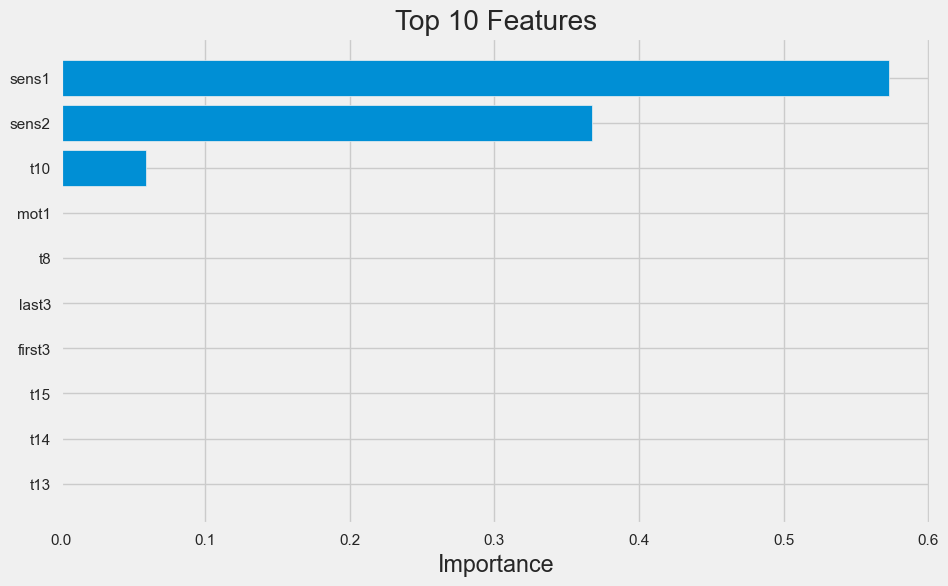

------------------- NSA2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 20.80
Mean Absolute Error (MAE): 19.33
R-squared (R2): -1.37
   Feature  Importance
4    sens2   0.116162 
21     t15   0.107147 
20     t14   0.086957 
17     t11   0.075764 
11      t5   0.066919 
19     t13   0.057671 
8       t2   0.054348 
5    sens3   0.053521 
15      t9   0.034082 
16     t10   0.033893 


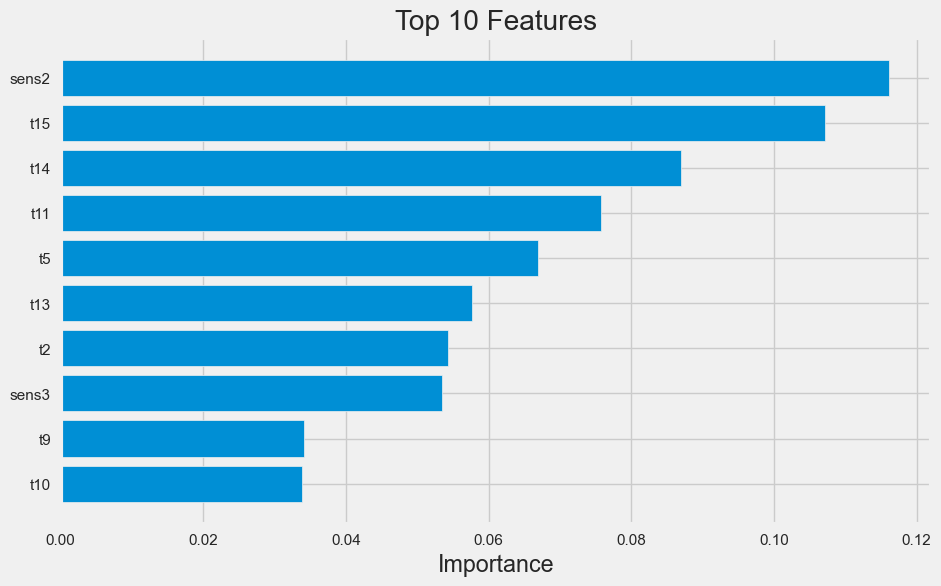

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 19.95
Mean Absolute Error (MAE): 18.65
R-squared (R2): -1.18
   Feature  Importance
4    sens2   0.574333 
3    sens1   0.357533 
0     mot1   0.065695 
5    sens3   0.002438 
14      t8   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 


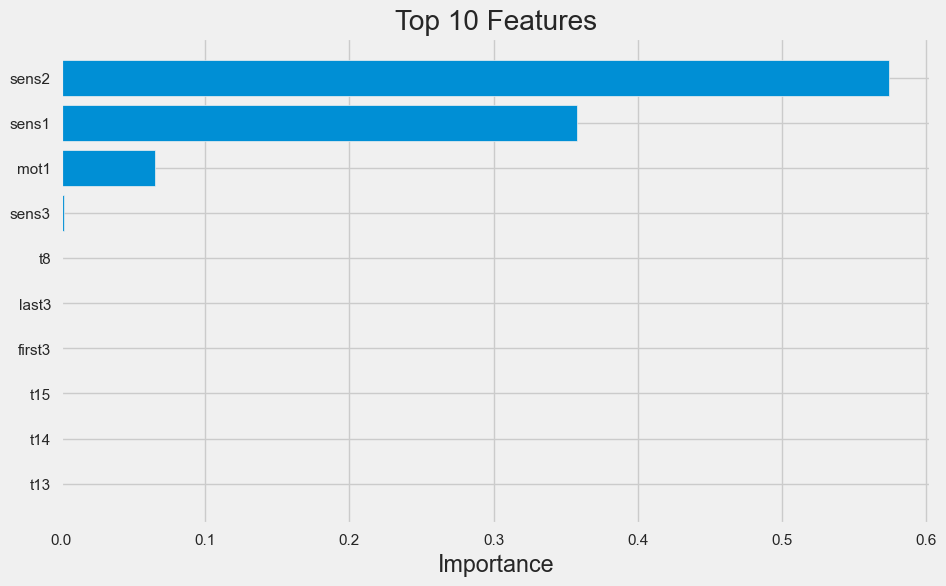

------------------- NSA3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 20.87
Mean Absolute Error (MAE): 19.01
R-squared (R2): -0.94
   Feature  Importance
4    sens2   0.108696 
21     t15   0.107240 
3    sens1   0.079967 
24  diff_t   0.065217 
17     t11   0.063250 
5    sens3   0.063207 
20     t14   0.054348 
11      t5   0.054348 
16     t10   0.036557 
19     t13   0.035300 


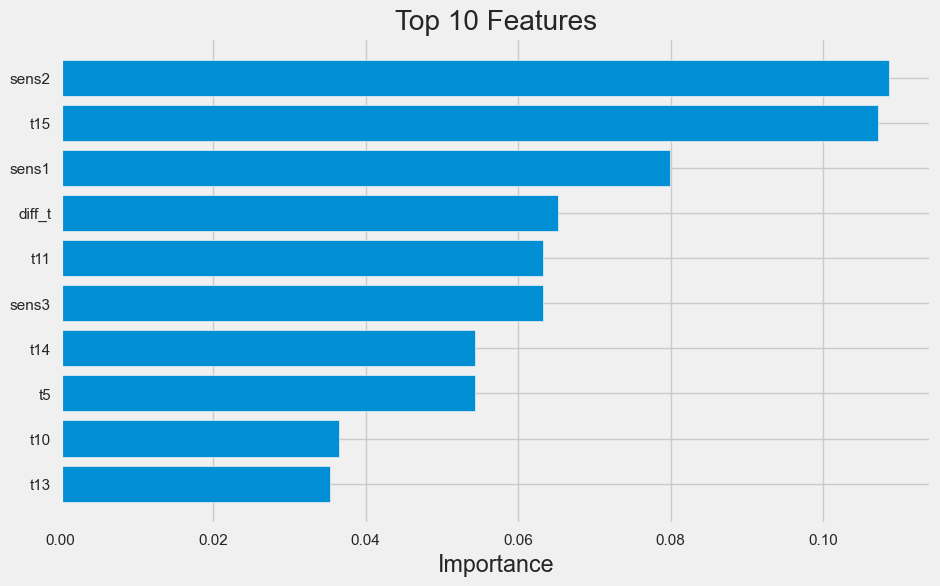

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 23.41
Mean Absolute Error (MAE): 23.05
R-squared (R2): -1.44
   Feature  Importance
4    sens2   0.492140 
16     t10   0.310123 
11      t5   0.052668 
5    sens3   0.049055 
2     mot3   0.035134 
0     mot1   0.021507 
1     mot2   0.016394 
6    slope   0.012434 
3    sens1   0.006011 
13      t7   0.004533 


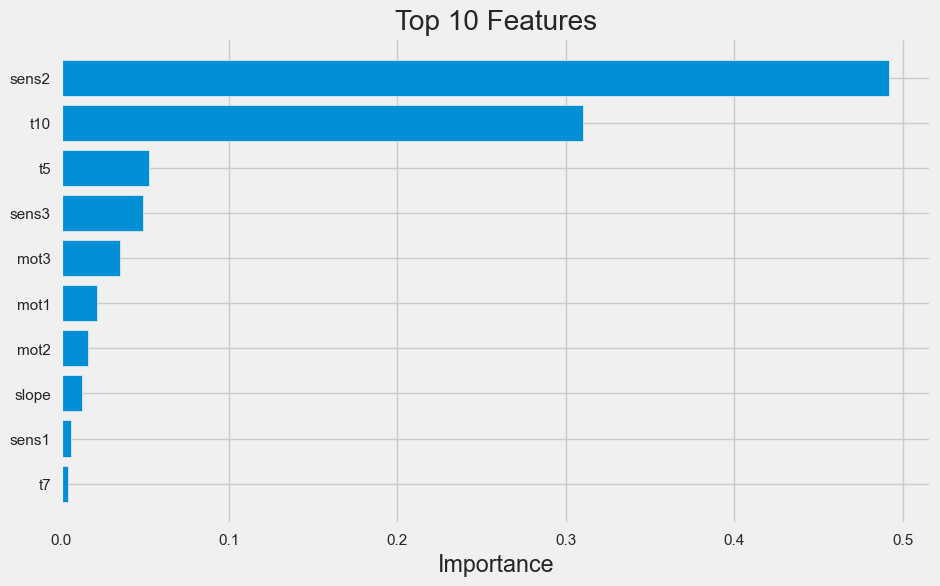

======================================== MT ========================================
------------------- MT1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 37.80
Mean Absolute Error (MAE): 31.20
R-squared (R2): 0.12
   Feature  Importance
24  diff_t   0.095745 
15      t9   0.088854 
12      t6   0.074453 
10      t4   0.069165 
3    sens1   0.050067 
6    slope   0.048068 
1     mot2   0.047872 
2     mot3   0.042601 
5    sens3   0.042512 
8       t2   0.040721 


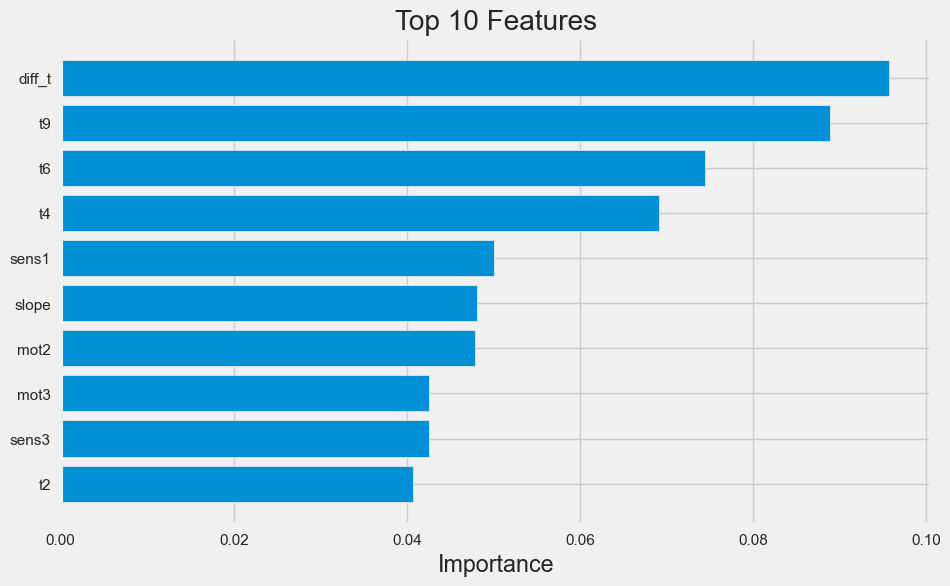

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 42.61
Mean Absolute Error (MAE): 39.28
R-squared (R2): -0.12
   Feature  Importance
6    slope   0.283143 
1     mot2   0.164415 
16     t10   0.154618 
5    sens3   0.154349 
2     mot3   0.124678 
13      t7   0.045495 
3    sens1   0.038817 
4    sens2   0.034484 
0     mot1   0.000000 
23   last3   0.000000 


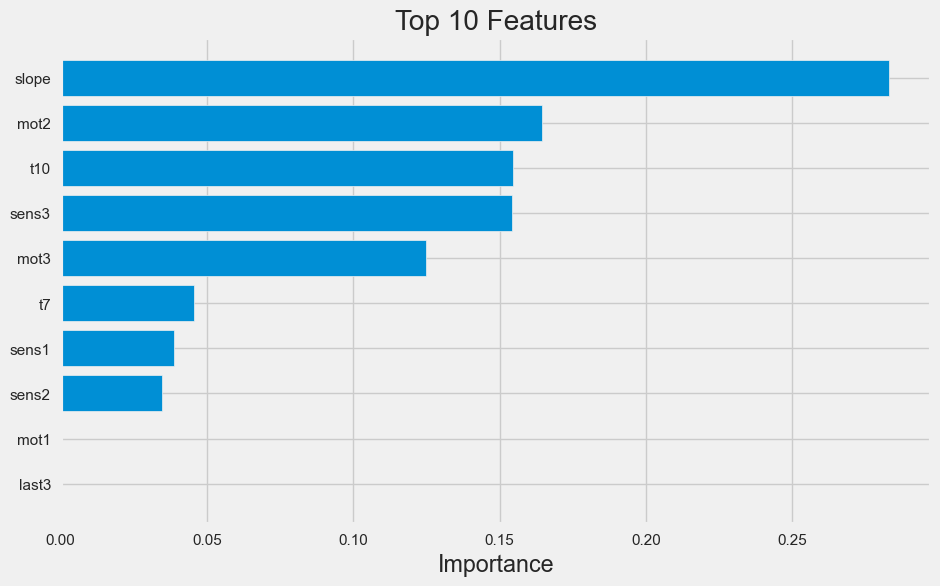

------------------- MT2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 28.39
Mean Absolute Error (MAE): 22.26
R-squared (R2): 0.16
   Feature  Importance
15      t9   0.101883 
24  diff_t   0.096615 
12      t6   0.085106 
10      t4   0.079808 
9       t3   0.053194 
3    sens1   0.047011 
4    sens2   0.043416 
6    slope   0.042575 
1     mot2   0.042553 
19     t13   0.038176 


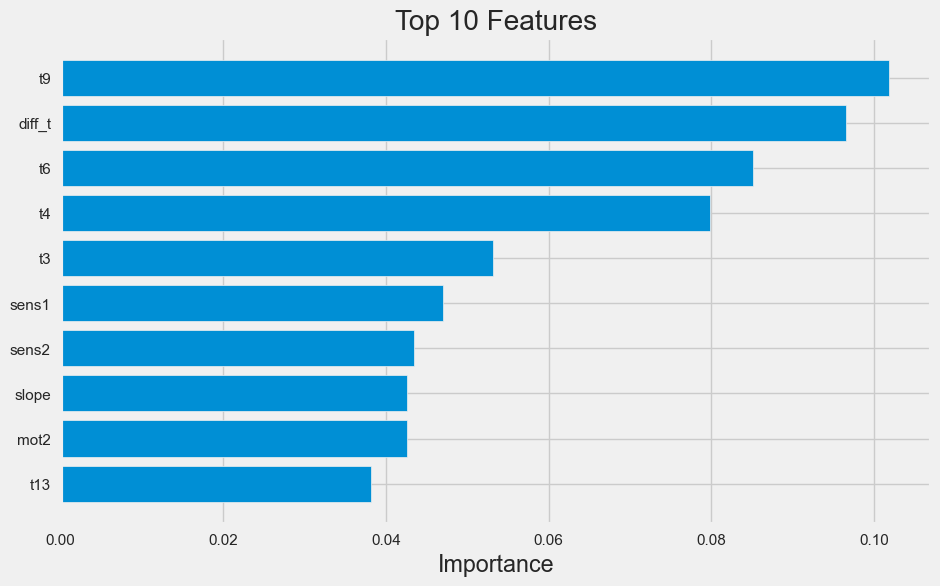

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 34.26
Mean Absolute Error (MAE): 29.87
R-squared (R2): -0.23
   Feature  Importance
6    slope   0.267300 
5    sens3   0.229077 
16     t10   0.221384 
2     mot3   0.145094 
1     mot2   0.107721 
4    sens2   0.010818 
13      t7   0.010317 
3    sens1   0.008288 
0     mot1   0.000000 
23   last3   0.000000 


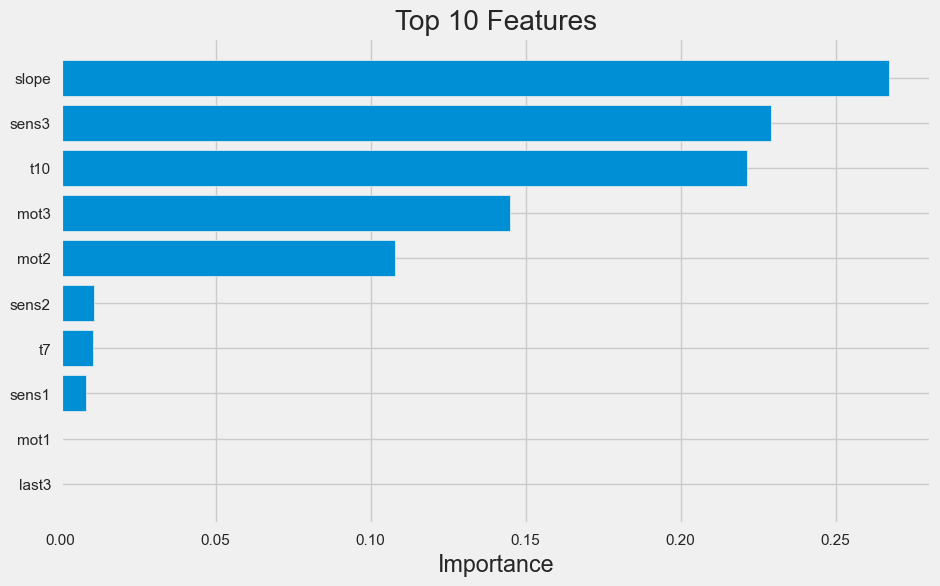

------------------- MT3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'poisson', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 9.49
Mean Absolute Error (MAE): 9.46
R-squared (R2): 0.80
   Feature  Importance
15      t9   0.091406 
12      t6   0.085106 
24  diff_t   0.085075 
10      t4   0.074525 
6    slope   0.058509 
9       t3   0.053161 
3    sens1   0.047912 
4    sens2   0.043481 
19     t13   0.042592 
1     mot2   0.042553 


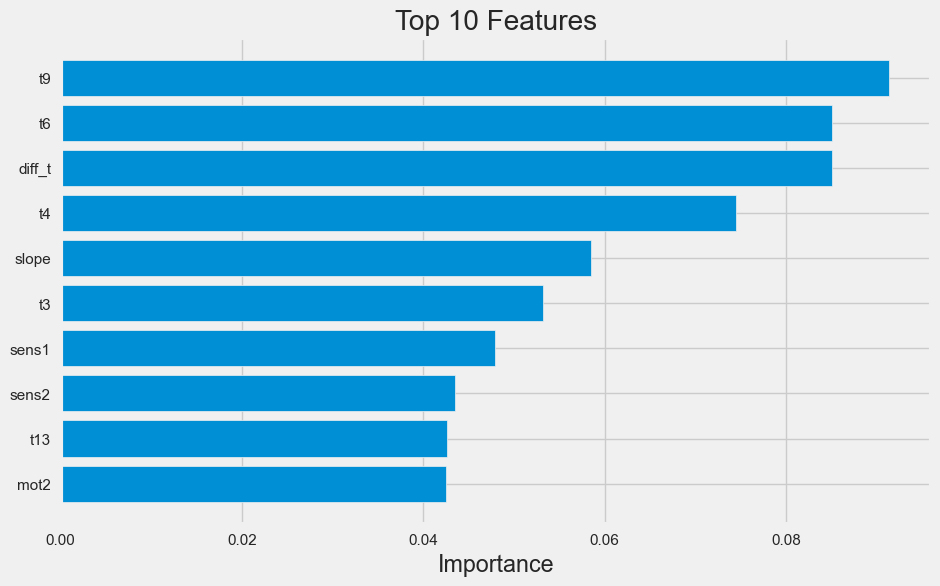

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 19.65
Mean Absolute Error (MAE): 19.25
R-squared (R2): 0.13
   Feature  Importance
6    slope   0.279247 
5    sens3   0.196094 
16     t10   0.189395 
2     mot3   0.169299 
1     mot2   0.079091 
4    sens2   0.031576 
13      t7   0.029866 
3    sens1   0.025430 
0     mot1   0.000000 
23   last3   0.000000 


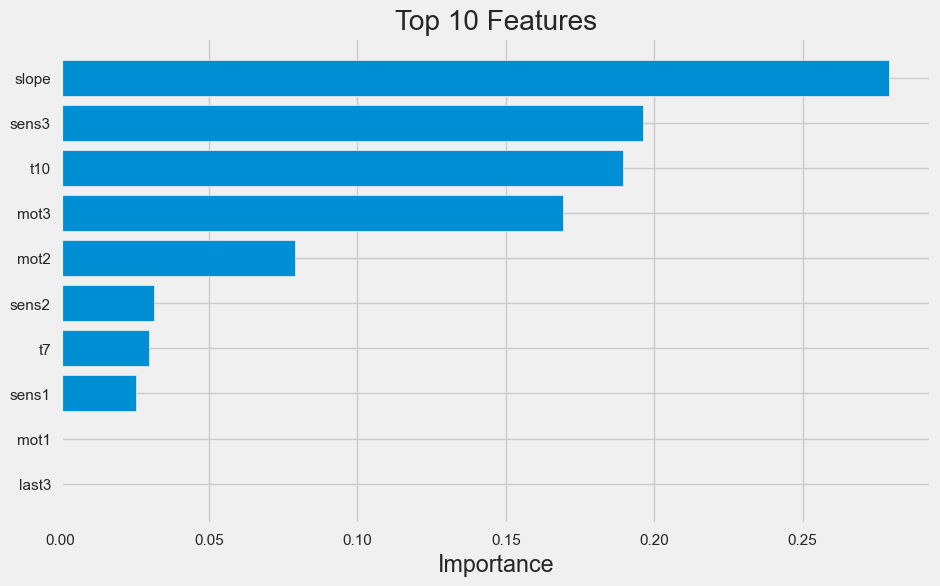

======================================== FAS ========================================
------------------- FAS1 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.89
Mean Absolute Error (MAE): 0.85
R-squared (R2): 0.56
   Feature  Importance
19     t13   0.103557 
15      t9   0.091952 
10      t4   0.081282 
24  diff_t   0.078959 
1     mot2   0.064504 
8       t2   0.061817 
12      t6   0.048475 
3    sens1   0.047020 
23   last3   0.042553 
7       t1   0.038240 


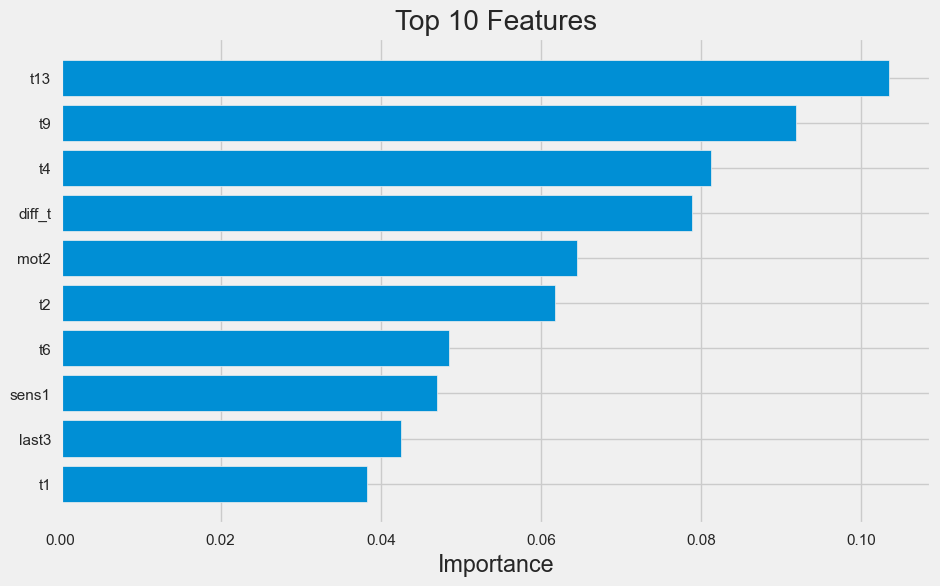

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 1.39
Mean Absolute Error (MAE): 1.36
R-squared (R2): -0.08
   Feature  Importance
6    slope   0.249046 
1     mot2   0.235834 
16     t10   0.170423 
5    sens3   0.166591 
2     mot3   0.119927 
0     mot1   0.027648 
4    sens2   0.014403 
13      t7   0.009285 
3    sens1   0.006842 
23   last3   0.000000 


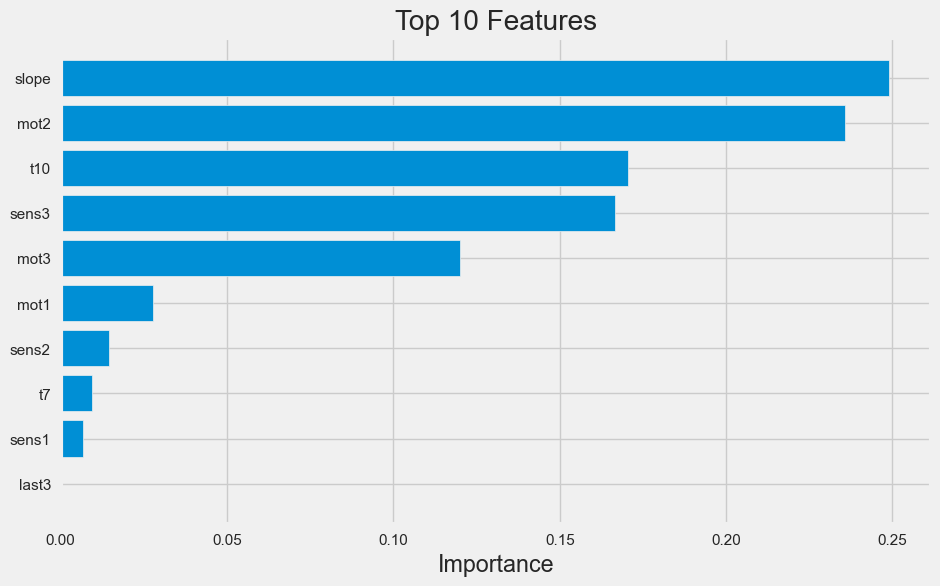

------------------- FAS2 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 1.20
Mean Absolute Error (MAE): 0.88
R-squared (R2): 0.19
   Feature  Importance
15      t9   0.114034 
24  diff_t   0.079267 
8       t2   0.073495 
19     t13   0.069898 
11      t5   0.069149 
10      t4   0.059407 
12      t6   0.058818 
7       t1   0.053058 
22  first3   0.053038 
23   last3   0.047712 


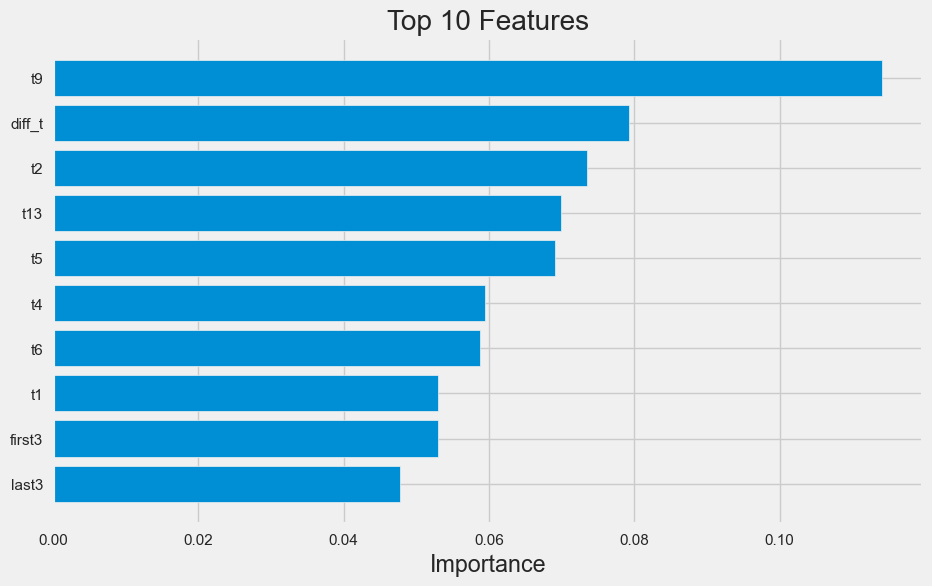

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 1.69
Mean Absolute Error (MAE): 1.41
R-squared (R2): -0.60
   Feature  Importance
0     mot1   0.900802 
11      t5   0.084374 
1     mot2   0.009220 
6    slope   0.005604 
14      t8   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 


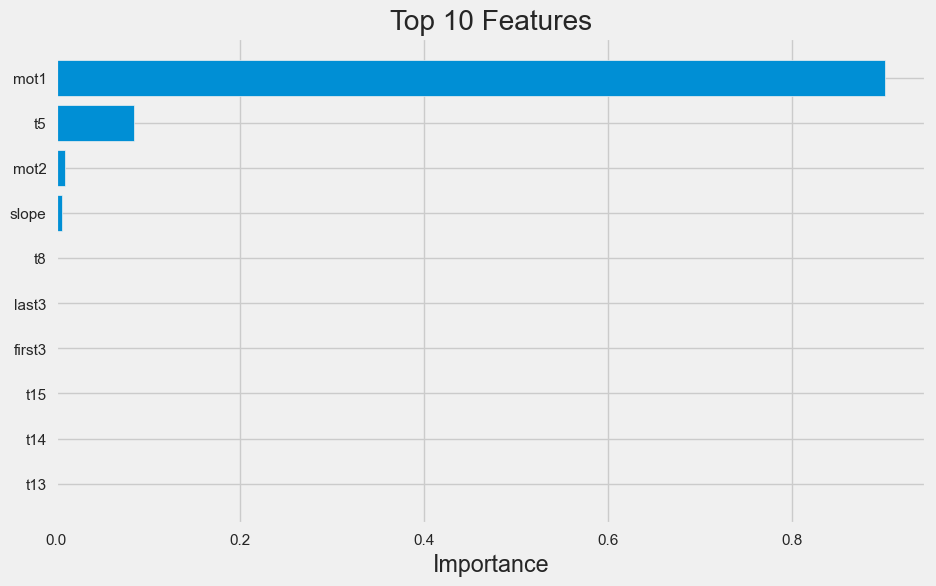

------------------- FAS3 -------------------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Random Forest - Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost - Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200}
RESULTS FOR RANDOM FOREST REGRESSOR
Root Mean Squared Error (RMSE): 0.90
Mean Absolute Error (MAE): 0.74
R-squared (R2): 0.30
   Feature  Importance
19     t13   0.119725 
15      t9   0.119305 
24  diff_t   0.074468 
10      t4   0.070348 
12      t6   0.059199 
1     mot2   0.058511 
11      t5   0.056996 
8       t2   0.050892 
22  first3   0.043428 
18     t12   0.041357 


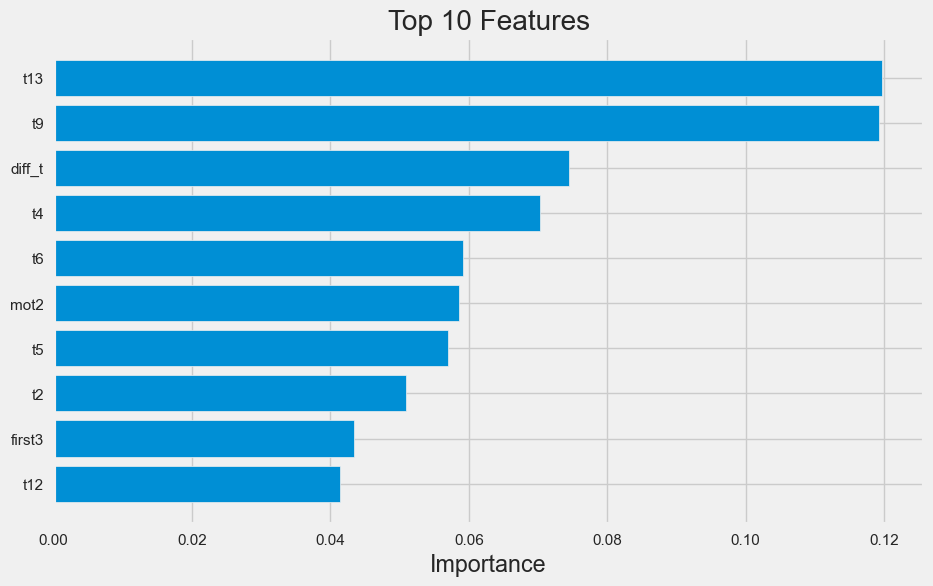

RESULTS FOR XGBOOST REGRESSOR
Root Mean Squared Error (RMSE): 1.33
Mean Absolute Error (MAE): 1.12
R-squared (R2): -0.51
   Feature  Importance
0     mot1   0.999167 
6    slope   0.000833 
13      t7   0.000000 
23   last3   0.000000 
22  first3   0.000000 
21     t15   0.000000 
20     t14   0.000000 
19     t13   0.000000 
18     t12   0.000000 
17     t11   0.000000 


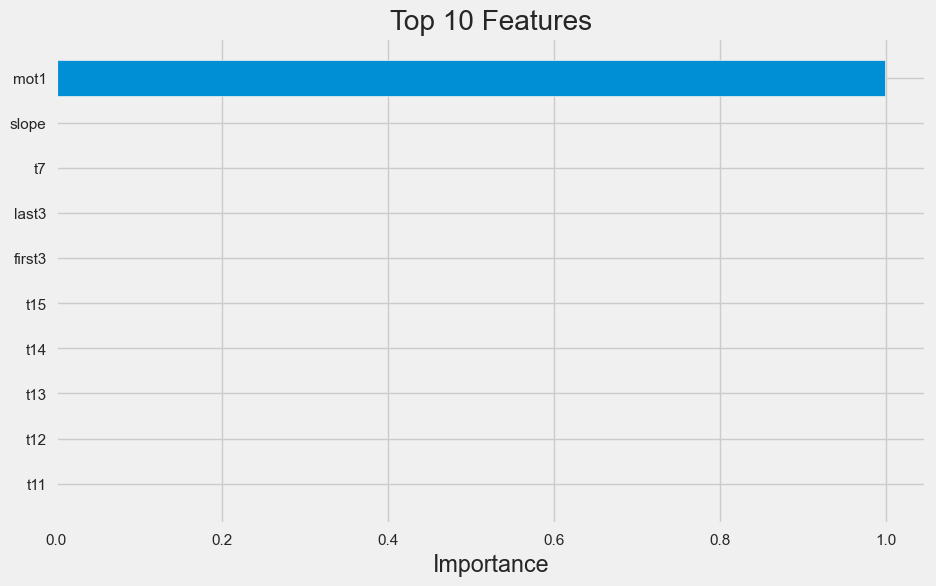

In [194]:
for score_to_study in scores:
    print("======================================== " + score_to_study + " ========================================")
    data = study_score(raw, score_to_study)
    X_train, X_test, y_trainset, y_testset = train_test_split_data(data, score_to_study)
    for i in range(1,4):
        post_score = score_to_study + str(i)
        print("------------------- " + post_score + " -------------------")
        y_train = y_trainset[post_score]
        y_test = y_testset[post_score]
        best_rf_model, best_xgb_model = tune_hyperparameter(X_train, X_test, y_train, y_test)
        run_mode(X_train, X_test, y_train, y_test, best_rf_model, model = "rf")
        run_mode(X_train, X_test, y_train, y_test, best_xgb_model, model = "xgb")